# Brain Tumor Detection

### Check GPU type installed

In [1]:
!nvidia-smi

Sun Jan 22 18:17:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare dataset

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset

In [3]:
!mkdir BrainTumorDataset

! unzip -qq /content/drive/MyDrive/BrainTumor/brain_tumor.zip -d BrainTumorDataset

### Import Packages

In [4]:
import os, cv2, random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB7

### Set dataset path and new image size

In [5]:
datasetPath = "/content/BrainTumorDataset/Brain Tumor Data Set/Brain Tumor Data Set/"
imageSize = 150

labelsMapping = {0: 'Healthy', 1: 'Brain Tumor'}

### Load dataset and divide into categories

In [6]:
def loadAndDivideIntoCategories(datasetPath, newImgSize):
  images, labels = list(), list()

  categories = os.listdir(datasetPath)
  for category in categories:
    categoryPath = datasetPath + "/" + category

    for imageName in os.listdir(categoryPath):
      if 'Healthy' in os.path.basename(os.path.normpath(categoryPath)):
          labels.append([1, 0])
      elif 'Brain Tumor' in os.path.basename(os.path.normpath(categoryPath)):
          labels.append([0, 1])
      imagePath = categoryPath + "/" + imageName
      images.append(cv2.resize(cv2.imread(imagePath), (newImgSize, newImgSize), interpolation=cv2.INTER_CUBIC))

            
  return images, labels

In [7]:
X, Y = loadAndDivideIntoCategories(datasetPath, imageSize)

### Split dataset into Train and Validation data

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1337)

### Visualize 5 random images

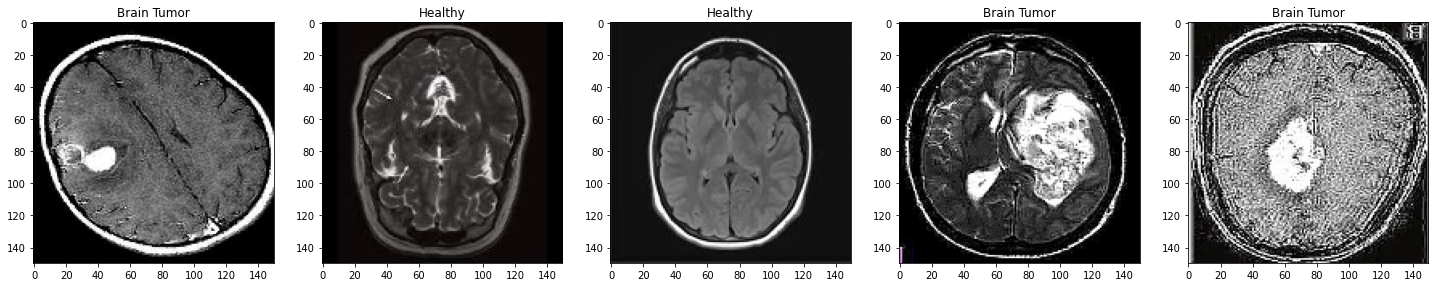

In [9]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
for i in range(5):
  idx = random.randint(0, len(X_train)-1)
  img, label = X_train[idx], Y_train[idx]

  axs[i].imshow(img)
  axs[i].set_title(labelsMapping[np.argmax(label)])

### Get number of training and validation examples, set batch size

In [10]:
trainExamplesNumber = len(X_train)
valExamplesNumber = len(X_val)
batch_size = 32
epochs = 40

print(f"Train examples: {trainExamplesNumber}. Test examples: {valExamplesNumber}. Batch size: {batch_size}. Epochs number {epochs}.")

Train examples: 3680. Test examples: 920. Batch size: 32. Epochs number 40.


### Real-Time Data Augumentation

In [11]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        # rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [12]:
trainGenerator = datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
valGenerator = datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

# Create and Train Models

### Functions to visualize results

In [ ]:
def plot_learning_curve(history, modelName, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))

    plt.figure(figsize=(7,7))

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(epochs, acc, 'r', label = 'Training accuracy')
    plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
    plt.title(f'Training and validation accuracy - {modelName}')
    plt.legend()

    plt.savefig(f'/content/drive/MyDrive/BrainTumor/LearningCurves/{modelName}-learning-curve')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

    plt.savefig(f'/content/drive/MyDrive/BrainTumor/ConfusionMatrices/{title}')
    plt.show()

def predict_for_all_images(model, X, Y):
  y_test = list()
  y_test_pred = list()


  for image, target in zip(X, Y):
    prediction = model.predict(np.array([image]), verbose=0)
    y_test_pred.append(np.argmax(prediction))
    y_test.append(np.argmax(target))
  
  return y_test, y_test_pred



## VGG16 Model

### Load pretrained model from the drive 

In [18]:
vgg16Model = keras.models.load_model('/content/drive/MyDrive/BrainTumor/Models/VGG16BrainTumor.h5')
vgg16Model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

### Create a model and print summary

In [ ]:
base_model_vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
)
x = base_model_vgg16.output
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(len(labelsMapping), activation='softmax')(x)

vgg16Model = keras.models.Model(inputs=base_model_vgg16.input, outputs=predictions)

for layer in base_model_vgg16.layers:
  # if layer.name == "block5_conv1":
  #   break
  layer.trainable = False

vgg16Model.summary()

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0  

### Compile and train the model

In [ ]:
vgg16Model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"],)

vgg16History = vgg16Model.fit(
    trainGenerator, 
    steps_per_epoch=trainExamplesNumber // batch_size,
    epochs=epochs,
    validation_data=valGenerator,
    validation_steps=valExamplesNumber // batch_size
)

Epoch 1/40
115/115 [==============================] - 26s 223ms/step - loss: 1.0261 - accuracy: 0.8052 - val_loss: 0.3657 - val_accuracy: 0.8806
Epoch 2/40
115/115 [==============================] - 25s 221ms/step - loss: 0.3887 - accuracy: 0.8769 - val_loss: 0.2675 - val_accuracy: 0.9051
Epoch 3/40
115/115 [==============================] - 25s 219ms/step - loss: 0.2720 - accuracy: 0.9033 - val_loss: 0.1992 - val_accuracy: 0.9219
Epoch 4/40
115/115 [==============================] - 25s 220ms/step - loss: 0.2075 - accuracy: 0.9231 - val_loss: 0.1905 - val_accuracy: 0.9241
Epoch 5/40
115/115 [==============================] - 25s 218ms/step - loss: 0.1797 - accuracy: 0.9348 - val_loss: 0.3819 - val_accuracy: 0.8538
Epoch 6/40
115/115 [==============================] - 25s 218ms/step - loss: 0.1572 - accuracy: 0.9457 - val_loss: 0.1461 - val_accuracy: 0.9442
Epoch 7/40
115/115 [==============================] - 25s 219ms/step - loss: 0.1315 - accuracy: 0.9535 - val_loss: 0.1551 - val_ac

### Visualize learning curve and confusion matrix

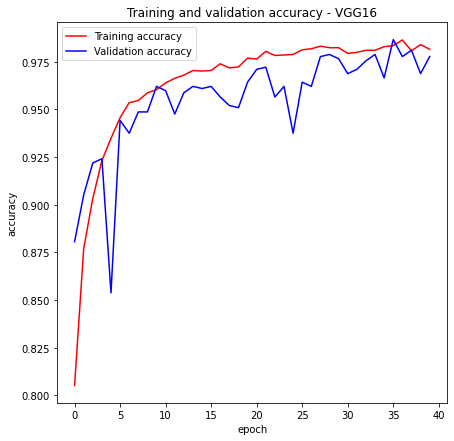

In [ ]:
plot_learning_curve(vgg16History, 'VGG16', 40)

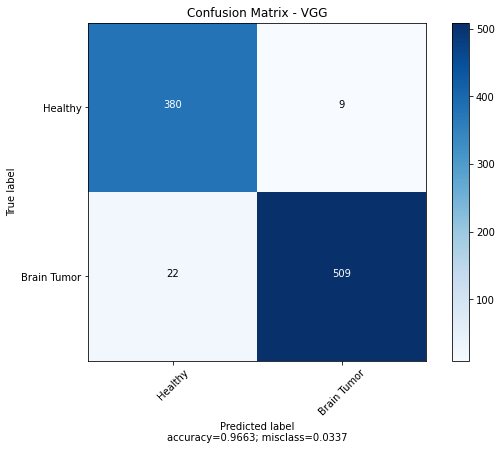

In [ ]:
y_test_vgg, y_test_pred_vgg = predict_for_all_images(vgg16Model, X_val, Y_val)

cm_vgg = confusion_matrix(y_test_vgg, y_test_pred_vgg)

plot_confusion_matrix(cm_vgg, 
                      normalize    = False,
                      target_names = labelsMapping.values(),
                      title        = "Confusion Matrix - VGG")

## EfficientNet Model

### Load pretrained model from the drive 

In [19]:
efficientNetModel = keras.models.load_model('/content/drive/MyDrive/BrainTumor/Models/efficientNetBrainTumor.h5')
efficientNetModel.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 150, 150, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

### Create a model and print summary

In [ ]:
base_model_efficient = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
)
# x = base_model_efficient.output
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.5)(x)
# predictions = keras.layers.Dense(len(labelsMapping), activation='softmax')(x)

x = base_model_efficient.output
x = keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(len(labelsMapping), activation='softmax')(x)

efficientNetModel = keras.models.Model(inputs=base_model_efficient.input, outputs=predictions)

for layer in base_model_efficient.layers:
    layer.trainable = False

efficientNetModel.summary()

258076736/258076736 [==============================] - 12s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLamb

### Compile and train the model

In [ ]:
efficientNetModel.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"],)

efficientNetHistory = efficientNetModel.fit(
    trainGenerator, 
    steps_per_epoch=trainExamplesNumber // batch_size,
    epochs=epochs,
    validation_data=valGenerator,
    validation_steps=valExamplesNumber // batch_size
)

Epoch 1/40
115/115 [==============================] - 66s 317ms/step - loss: 0.4289 - accuracy: 0.8454 - val_loss: 0.2472 - val_accuracy: 0.9062
Epoch 2/40
115/115 [==============================] - 32s 278ms/step - loss: 0.2456 - accuracy: 0.9024 - val_loss: 0.1650 - val_accuracy: 0.9297
Epoch 3/40
115/115 [==============================] - 31s 270ms/step - loss: 0.2009 - accuracy: 0.9193 - val_loss: 0.1397 - val_accuracy: 0.9453
Epoch 4/40
115/115 [==============================] - 31s 272ms/step - loss: 0.1710 - accuracy: 0.9361 - val_loss: 0.1500 - val_accuracy: 0.9408
Epoch 5/40
115/115 [==============================] - 31s 270ms/step - loss: 0.1554 - accuracy: 0.9432 - val_loss: 0.1248 - val_accuracy: 0.9475
Epoch 6/40
115/115 [==============================] - 31s 270ms/step - loss: 0.1286 - accuracy: 0.9492 - val_loss: 0.1082 - val_accuracy: 0.9542
Epoch 7/40
115/115 [==============================] - 32s 274ms/step - loss: 0.1381 - accuracy: 0.9489 - val_loss: 0.0991 - val_ac

### Visualize learning curve and confusion matrix

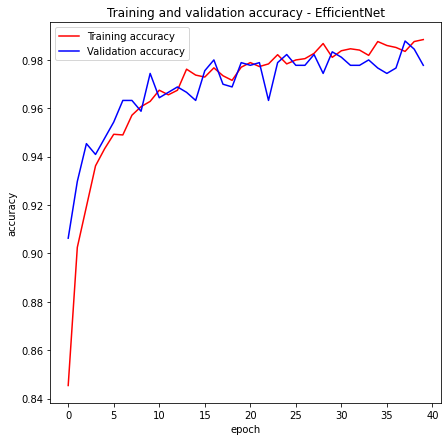

In [ ]:
plot_learning_curve(efficientNetHistory, 'EfficientNet', 40)

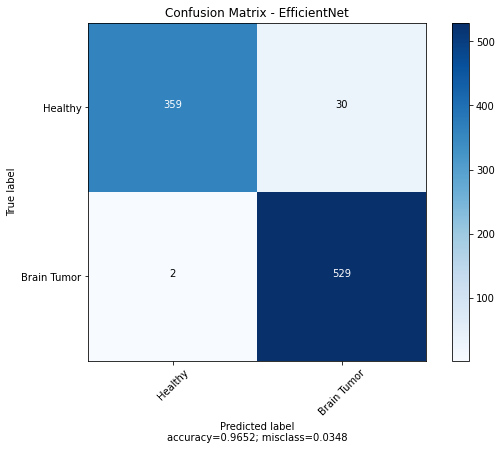

In [ ]:
y_test_eff, y_test_pred_eff = predict_for_all_images(efficientNetModel, X_val, Y_val)

cm_eff = confusion_matrix(y_test_eff, y_test_pred_eff)

plot_confusion_matrix(cm_eff, 
                      normalize    = False,
                      target_names = labelsMapping.values(),
                      title        = "Confusion Matrix - EfficientNet")

## ResNet Model

### Load pretrained model from the drive 

In [13]:
resnetModel = keras.models.load_model('/content/drive/MyDrive/BrainTumor/Models/ResNetBrainTumor.h5')
resnetModel.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

### Create a model and print summary

In [ ]:
# base_model = ResNet50(weights='imagenet', include_top=False)
# x = base_model.output
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.5)(x)
# predictions = keras.layers.Dense(len(labelsMapping), activation='softmax')(x)

# resnetModel = keras.models.Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# resnetModel.summary()

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(len(labelsMapping), activation='softmax')(x)

resnetModel = keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

resnetModel.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                           

### Compile and train the model

In [ ]:
resnetModel.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"],)

resnetHistory = resnetModel.fit(
    trainGenerator, 
    steps_per_epoch=trainExamplesNumber // batch_size,
    epochs=epochs,
    validation_data=valGenerator,
    validation_steps=valExamplesNumber // batch_size
)

Epoch 1/40
115/115 [==============================] - 30s 236ms/step - loss: 0.0960 - accuracy: 0.9712 - val_loss: 0.1173 - val_accuracy: 0.9576
Epoch 2/40
115/115 [==============================] - 24s 207ms/step - loss: 0.0669 - accuracy: 0.9755 - val_loss: 0.1450 - val_accuracy: 0.9643
Epoch 3/40
115/115 [==============================] - 24s 207ms/step - loss: 0.0613 - accuracy: 0.9810 - val_loss: 0.1469 - val_accuracy: 0.9710
Epoch 4/40
115/115 [==============================] - 26s 223ms/step - loss: 0.0647 - accuracy: 0.9783 - val_loss: 0.1073 - val_accuracy: 0.9777
Epoch 5/40
115/115 [==============================] - 24s 208ms/step - loss: 0.0637 - accuracy: 0.9793 - val_loss: 0.0945 - val_accuracy: 0.9754
Epoch 6/40
115/115 [==============================] - 27s 234ms/step - loss: 0.0533 - accuracy: 0.9832 - val_loss: 0.1033 - val_accuracy: 0.9699
Epoch 7/40
115/115 [==============================] - 25s 215ms/step - loss: 0.0654 - accuracy: 0.9807 - val_loss: 0.1808 - val_ac

### Visualize learning curve and confusion matrix

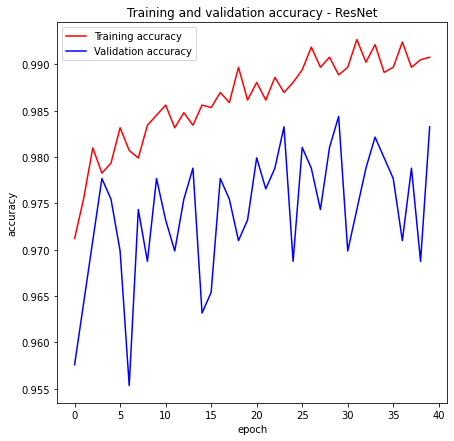

In [ ]:
plot_learning_curve(resnetHistory, 'ResNet', 40)

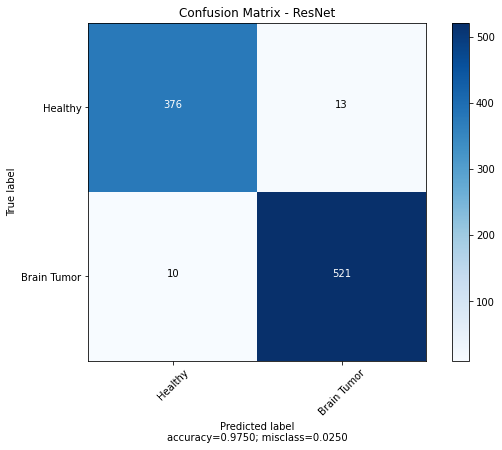

In [ ]:
y_test_resnet, y_test_pred_resnet = predict_for_all_images(resnetModel, X_val, Y_val)

cm_resnet = confusion_matrix(y_test_resnet, y_test_pred_resnet)

plot_confusion_matrix(cm_resnet, 
                      normalize    = False,
                      target_names = labelsMapping.values(),
                      title        = "Confusion Matrix - ResNet")

## CNN Model

### Load pretrained model from the drive 

In [20]:
modelCNN = keras.models.load_model('/content/drive/MyDrive/BrainTumor/Models/CNNBrainTumor_2.h5')
modelCNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 149, 149, 16)      208       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 22, 22, 64)       

### Create a model and print summary

In [ ]:
# modelCNN = keras.Sequential(
#   [
#       keras.Input(shape=(imageSize, imageSize, 3)),
#       layers.experimental.preprocessing.Rescaling(1.0 / 255),
#       layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Flatten(),
#       layers.Dropout(0.5),
#       layers.Dense(len(labelsMapping), activation="softmax"),
#   ]
# )

# modelCNN = keras.Sequential(
#   [
#       keras.Input(shape=(imageSize, imageSize, 3)),
#       layers.experimental.preprocessing.Rescaling(1.0 / 255),
#       layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(3, 3)),
#       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Flatten(),
#       layers.Dropout(0.5),
#       layers.Dense(len(labelsMapping), activation="softmax"),
#   ]
# )

# modelCNN = keras.Sequential(
#   [
#       keras.Input(shape=(imageSize, imageSize, 3)),
#       layers.experimental.preprocessing.Rescaling(1.0 / 255),
#       layers.Conv2D(16, kernel_size=(2, 2), activation="relu"),
#       layers.MaxPooling2D(pool_size=(2, 2)),
#       layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(3, 3)),
#       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(3, 3)),
#       layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
#       layers.MaxPooling2D(pool_size=(3, 3)),
#       layers.Flatten(),
#       layers.Dropout(0.5),
#       layers.Dense(len(labelsMapping), activation="softmax"),
#   ]
# )

modelCNN = keras.Sequential(
  [
      keras.Input(shape=(imageSize, imageSize, 3)),
      layers.experimental.preprocessing.Rescaling(1.0 / 255),
      layers.Conv2D(16, kernel_size=(2, 2), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(3, 3)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(3, 3)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(3, 3)),
      # layers.Dense(512, activation='relu'),
      layers.GlobalAveragePooling2D(),
      layers.Dense(len(labelsMapping), activation="softmax"),
  ]
)

modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 149, 149, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        1

### Compile and train the model

In [ ]:
modelCNN.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

historyCNN = modelCNN.fit(
    trainGenerator, 
    steps_per_epoch=trainExamplesNumber // batch_size,
    epochs=epochs,
    validation_data=valGenerator,
    validation_steps=valExamplesNumber // batch_size
)

Epoch 1/40
115/115 [==============================] - 23s 188ms/step - loss: 0.6794 - accuracy: 0.5739 - val_loss: 0.6440 - val_accuracy: 0.6585
Epoch 2/40
115/115 [==============================] - 21s 185ms/step - loss: 0.6209 - accuracy: 0.6622 - val_loss: 0.5889 - val_accuracy: 0.6908
Epoch 3/40
115/115 [==============================] - 21s 186ms/step - loss: 0.5835 - accuracy: 0.6872 - val_loss: 0.6354 - val_accuracy: 0.6484
Epoch 4/40
115/115 [==============================] - 22s 187ms/step - loss: 0.5626 - accuracy: 0.7103 - val_loss: 0.5689 - val_accuracy: 0.7076
Epoch 5/40
115/115 [==============================] - 22s 190ms/step - loss: 0.5373 - accuracy: 0.7364 - val_loss: 0.5113 - val_accuracy: 0.7489
Epoch 6/40
115/115 [==============================] - 22s 188ms/step - loss: 0.5071 - accuracy: 0.7524 - val_loss: 0.5092 - val_accuracy: 0.7254
Epoch 7/40
115/115 [==============================] - 22s 188ms/step - loss: 0.4788 - accuracy: 0.7685 - val_loss: 0.4703 - val_ac

### Visualize learning curve and confusion matrix

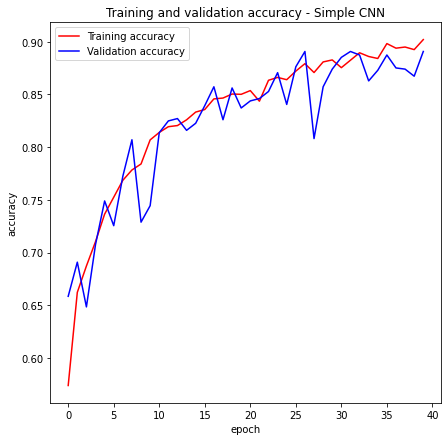

In [ ]:
plot_learning_curve(historyCNN, 'Simple CNN', 40)

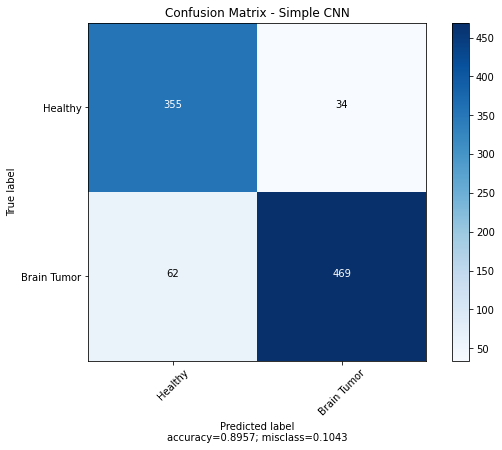

In [ ]:
y_test_cnn, y_test_pred_cnn = predict_for_all_images(modelCNN, X_val, Y_val)

cm_cnn = confusion_matrix(y_test_cnn, y_test_pred_cnn)

plot_confusion_matrix(cm_cnn, 
                      normalize    = False,
                      target_names = labelsMapping.values(),
                      title        = "Confusion Matrix - Simple CNN")

## Save all trained models for further use

In [ ]:
modelCNN.save("/content/drive/MyDrive/BrainTumor/Models/CNNBrainTumor.h5")
resnetModel.save("/content/drive/MyDrive/BrainTumor/Models/ResNetBrainTumor.h5")
vgg16Model.save("/content/drive/MyDrive/BrainTumor/Models/VGG16BrainTumor.h5")
efficientNetModel.save("/content/drive/MyDrive/BrainTumor/Models/efficientNetBrainTumor.h5")

# Saliency maps

## Prepare last conv layers names and input image

### Set last convolutional layers names

In [14]:
last_conv_layer_name_cnn = "conv2d_19"
last_conv_layer_name_resnet = "conv2d_2"
last_conv_layer_name_vgg16 = "block5_conv3"
last_conv_layer_name_efficientnet = "conv2d_1"

### Get and display input image

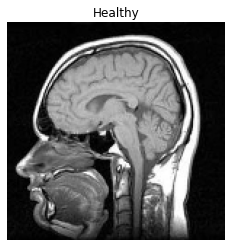

In [36]:
# idx = random.randint(0, len(X_val)) # 76- gooood
idx = 9 #[16, 40, 184, 299, 332, 354, 387, 435, 532, 672, 684, 704]
img = X_val[idx]
label = Y_val[idx]
img_array = img 
plt.imshow(img)
plt.title(labelsMapping[np.argmax(label)])
plt.axis('off')
plt.show()

## Gradcam

### biggest diff center of mass

In [ ]:
# diff = np.abs(np.mean(resnetCenters,axis=1) - np.mean(efficientnetCenters,axis=1))
# ind = np.argpartition(diff, -5)[-5:]
# print(ind)

# plt.plot(diff)
# plt.show()

### Import gradcam from prepared saliency_maps library

In [30]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/BrainTumor/')

from saliency_maps import gradcam

### Predict result for all architectures

In [37]:
predictionCNN = modelCNN.predict(np.array([img_array]), verbose=0)
predictionResNet = resnetModel.predict(np.array([img_array]), verbose=0)
predictionVgg16 = vgg16Model.predict(np.array([img_array]), verbose=0)
predictionEfficientNet = efficientNetModel.predict(np.array([img_array]), verbose=0)

print(f"CNN -- {labelsMapping[np.argmax(predictionCNN)]} -- probability={np.max(predictionCNN)}")
print(f"Resnet -- {labelsMapping[np.argmax(predictionResNet)]} -- probability={np.max(predictionResNet)}")
print(f"VGG -- {labelsMapping[np.argmax(predictionVgg16)]} -- probability={np.max(predictionVgg16)}")
print(f"EfficientNet -- {labelsMapping[np.argmax(predictionEfficientNet)]} -- probability={np.max(predictionEfficientNet)}")

CNN -- Healthy -- probability=0.763035774230957
Resnet -- Healthy -- probability=1.0
VGG -- Healthy -- probability=1.0
EfficientNet -- Healthy -- probability=1.0


### Create and display GradCAM Saliency Maps

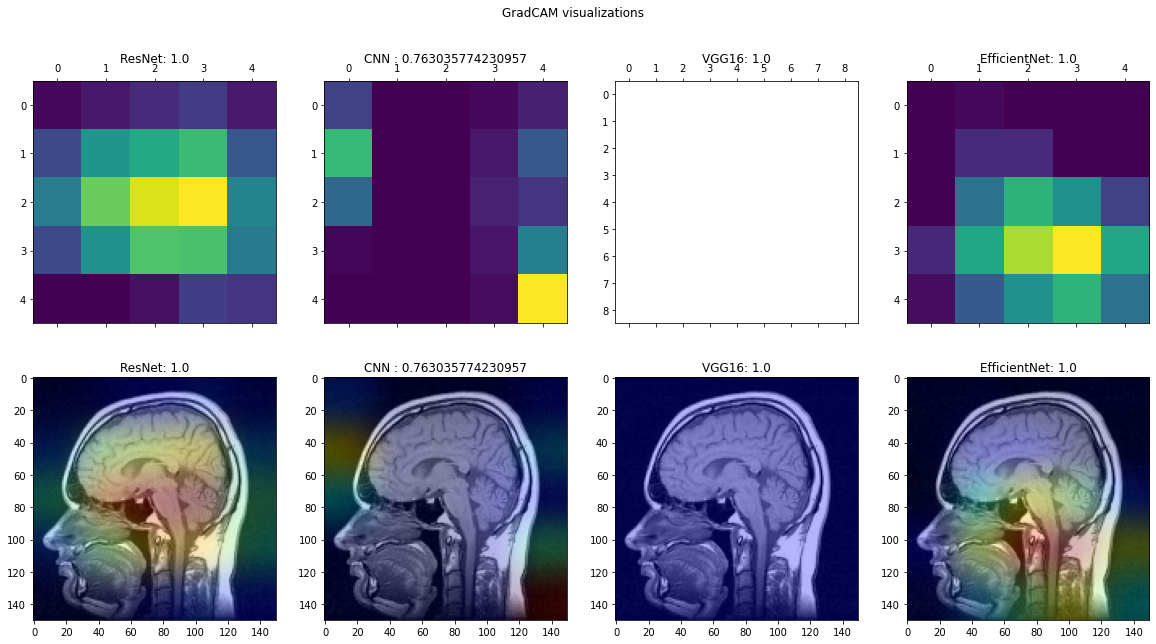

In [55]:
heatmapResNet = gradcam.make_gradcam_heatmap(np.array([img_array]), resnetModel, last_conv_layer_name_resnet)
heatmapCNN = gradcam.make_gradcam_heatmap(np.array([img_array]), modelCNN, last_conv_layer_name_cnn)
heatmapVgg16 = gradcam.make_gradcam_heatmap(np.array([img_array]), vgg16Model, last_conv_layer_name_vgg16)
heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([img_array]), efficientNetModel, last_conv_layer_name_efficientnet)

fig, axs = plt.subplots(2, 4, figsize=(20, 10)) 

fig.suptitle("GradCAM visualizations")

axs[0, 0].matshow(heatmapResNet)
axs[0, 0].set_title(f"ResNet: {np.max(predictionResNet)}")

axs[0, 1].matshow(heatmapCNN)
axs[0, 1].set_title(f"CNN : {np.max(predictionCNN)}")

axs[0, 2].matshow(heatmapVgg16)
axs[0, 2].set_title(f"VGG16: {np.max(predictionVgg16)}")

axs[0, 3].matshow(heatmapEfficientNet)
axs[0, 3].set_title(f"EfficientNet: {np.max(predictionEfficientNet)}")

gradcamResNet = gradcam.save_and_display_gradcam(img, heatmapResNet)
gradcamCNN = gradcam.save_and_display_gradcam(img, heatmapCNN)
gradcamVgg16 = gradcam.save_and_display_gradcam(img, heatmapVgg16)
gradcamEfficientNet = gradcam.save_and_display_gradcam(img, heatmapEfficientNet)

axs[1, 0].imshow(gradcamResNet)
axs[1, 0].set_title(f"ResNet: {np.max(predictionResNet)}")

axs[1, 1].imshow(gradcamCNN)
axs[1, 1].set_title(f"CNN : {np.max(predictionCNN)}")

axs[1, 2].imshow(gradcamVgg16)
axs[1, 2].set_title(f"VGG16: {np.max(predictionVgg16)}")

axs[1, 3].imshow(gradcamEfficientNet)
axs[1, 3].set_title(f"EfficientNet: {np.max(predictionEfficientNet)}")

plt.show()

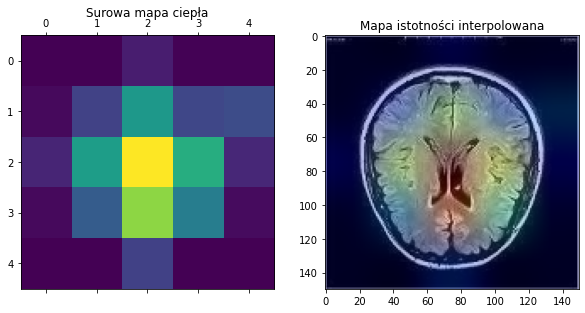

In [ ]:
heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([img_array]), efficientNetModel, last_conv_layer_name_efficientnet)
gradcamEfficientNet = gradcam.save_and_display_gradcam(img, heatmapEfficientNet)

fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

axs[0].matshow(heatmapEfficientNet)
axs[0].set_title("Surowa mapa ciepła")
axs[1].imshow(gradcamEfficientNet)
axs[1].set_title("Mapa istotności interpolowana")
#axs[1].set_title(f"EfficientNet: {labelsMapping[np.argmax(predictionEfficientNet)]}")

plt.show()

### Wnioski:
- VGG często skupia się na środku obrazka, może jest w tym jakiś sens?
- CNN bardzo dobrze radzi sobie w przypadku białych owalnych guzów na tle ciemniejszego mózgu.
- Najlepsze wyniki zwraca ResNet.
- Może warto porównać takie wyniki z wynikami po preprocessingu zdjęć (usunięcie czarnego tła dookoła zdjęć i wtedy rozszerzenie?).
- W przypadku zdrowego mózgu często sieci skupiają się na całym mózgu.
- Resnet powiedział że chory mózg, mimo że był zdrowy, ale skupiał się na fragmencie prawie poza mózgiem, więc wiadomo, że źle.
- W przypadku zdjęc z boku czaszki prosta sieć często skupia się na obwodzie głowy, czyli na tym, w jaki sposób zrobiono zdjęcie.
- Zdarzają się zdjęcia, gdzie każda sieć skupia się kompletnie na czymś innym, mimo że dla większości zdjęć odpowiedzi są dość spójne.
- Saliency Mapy pozwalają wybrać architekturę, która działa najlepiej. Na przykład pomimo że ResNet i EfficientNet mają taką samą skuteczność (mniej, więcej) to po Saliency mapach możemy zauważyć, że efficient net skupia się na znacznie bardziej sensownych częściach zdjęcia. VGG ma ponad 93% a skupia się z piczy często.
- EfficientNet zazwyczaj skupia się na prawie całym mózgu, szczególnie na guzie, a resnet tylko na guzie
- Gdy wynik to równe 0 i 1 to się wywala.
- VGG skupia się prawie zawsze na mniejszych obszarach, EfficientNet na większych.
- CNN gdy podejmie dobrą decyzję to podejmuje ją na podstawie samego guza? W sensie skupia się na bardzo poprawnych częściach zdjęcia
- Dla VGG czasami heatmapa się nie generuje

### Skuteczności:
- CNN: 83%
- VGG19: 93%
- ResNet: 95%
- EfficientNet: 96%

## CAM

### Import CAM from saliency_maps library

In [ ]:
from saliency_maps import cam

### Create and display CAM saliency maps 

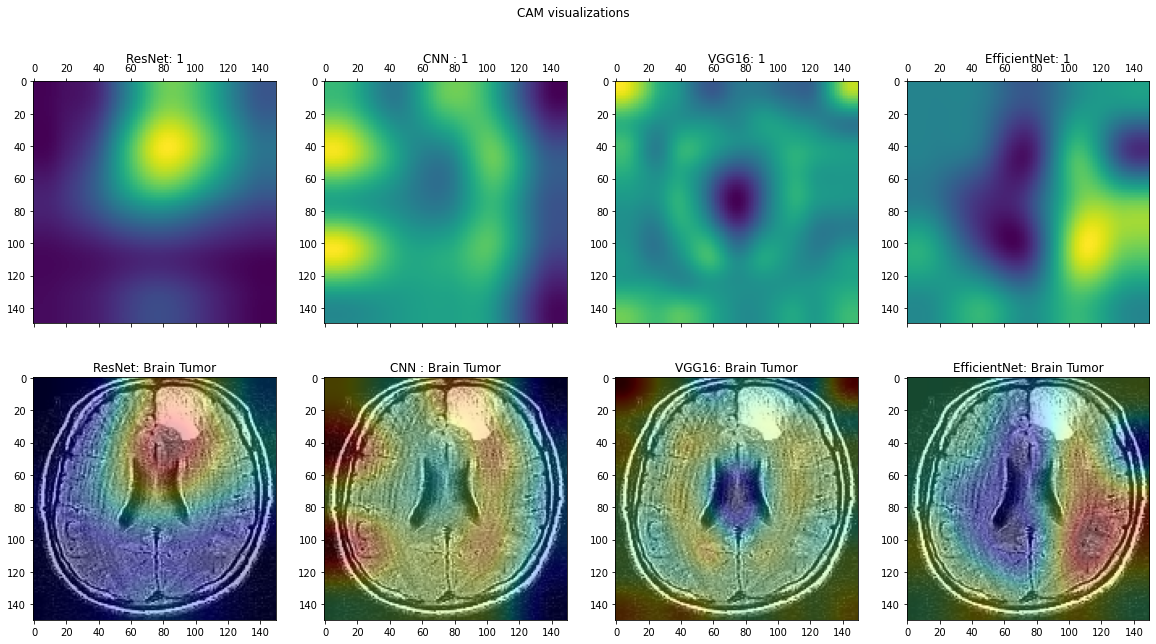

In [ ]:
heatmapCamResnet, predictionResnet = cam.get_class_activation_map(resnetModel, img_array, last_conv_layer_name_resnet)
camResnet = cam.save_and_display_cam(img, heatmapCamResnet)

heatmapCamCNN, predictionCNN = cam.get_class_activation_map(modelCNN, img_array, last_conv_layer_name_cnn)
camCNN = cam.save_and_display_cam(img, heatmapCamCNN)

heatmapCamVgg, predictionVgg = cam.get_class_activation_map(vgg16Model, img_array, last_conv_layer_name_vgg16)
camVgg = cam.save_and_display_cam(img, heatmapCamVgg)

heatmapCamEfficient, predictionEfficientNet = cam.get_class_activation_map(efficientNetModel, img_array, last_conv_layer_name_efficientnet)
camEfficient = cam.save_and_display_cam(img, heatmapCamEfficient)

fig, axs = plt.subplots(2, 4, figsize=(20, 10)) 

fig.suptitle("CAM visualizations")

axs[0, 0].matshow(heatmapCamResnet)
axs[0, 0].set_title(f"ResNet: {np.max(predictionResNet)}")

axs[0, 1].matshow(heatmapCamCNN)
axs[0, 1].set_title(f"CNN : {np.max(predictionCNN)}")

axs[0, 2].matshow(heatmapCamVgg)
axs[0, 2].set_title(f"VGG16: {np.max(predictionVgg16)}")

axs[0, 3].matshow(heatmapCamEfficient)
axs[0, 3].set_title(f"EfficientNet: {np.max(predictionEfficientNet)}")

axs[1, 0].imshow(camResnet)
axs[1, 0].set_title(f"ResNet: {labelsMapping[predictionResNet]}")

axs[1, 1].imshow(camCNN)
axs[1, 1].set_title(f"CNN : {labelsMapping[predictionCNN]}")

axs[1, 2].imshow(camVgg)
axs[1, 2].set_title(f"VGG16: {labelsMapping[predictionVgg16]}")

axs[1, 3].imshow(camEfficient)
axs[1, 3].set_title(f"EfficientNet: {labelsMapping[predictionEfficientNet]}")

plt.show()

## Guided Backpropagation

### From saliency_maps library import Guided Backpropagation methods

In [ ]:
from saliency_maps import guided_backprop

In [ ]:
# import tensorflow as tf

# @tf.RegisterGradient("GuidedRelu")
# def _GuidedReluGrad(op, grad):
#    gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
#    gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
#    return gate_f * gate_R * grad

# model = modelCNN
# with tf.compat.v1.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
#   gb_model = Model(
#       inputs = [model.inputs],
#       outputs = [model.get_layer("conv2d_3").output]
#   )
  
#   with tf.GradientTape() as tape:
#     inputs = tf.cast(img_array, tf.float32)
#     tape.watch(inputs)
#     outputs = gb_model(inputs)

# grads = tape.gradient(outputs,inputs)[0]  

### Create and display Guided Backprop Saliency Maps

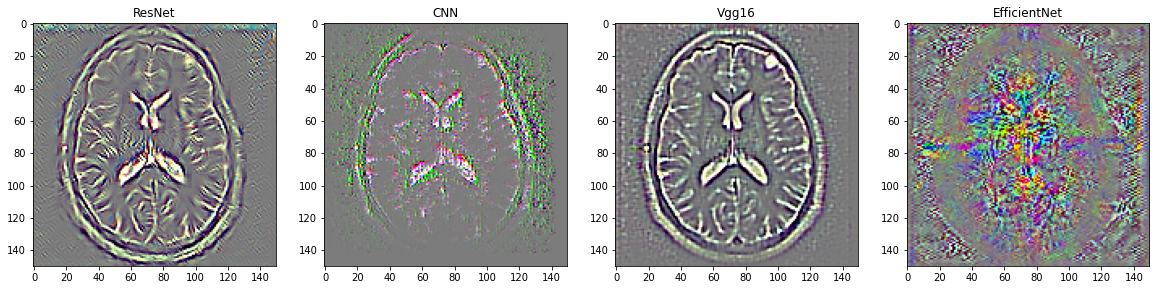

In [ ]:
guidedBackpropResnet = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, img_array)
guidedBackpropCNN = guided_backprop.create_saliency_map(modelCNN, last_conv_layer_name_cnn, img_array)
guidedBackpropVgg16 = guided_backprop.create_saliency_map(vgg16Model, last_conv_layer_name_vgg16, img_array)
guidedBackpropEfficientnet = guided_backprop.create_saliency_map(efficientNetModel, last_conv_layer_name_efficientnet, img_array)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)

axs[0].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
axs[0].set_title("ResNet")

axs[1].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))
axs[1].set_title("CNN")

axs[2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVgg16)),-1))
axs[2].set_title("Vgg16")

axs[3].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficientnet)),-1))
axs[3].set_title("EfficientNet")

plt.show()

## Guided Grad-CAM

### Import needed packages

In [ ]:
from saliency_maps import guided_backprop, gradcam

### Create Guided Grad-CAM visualization

nan


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


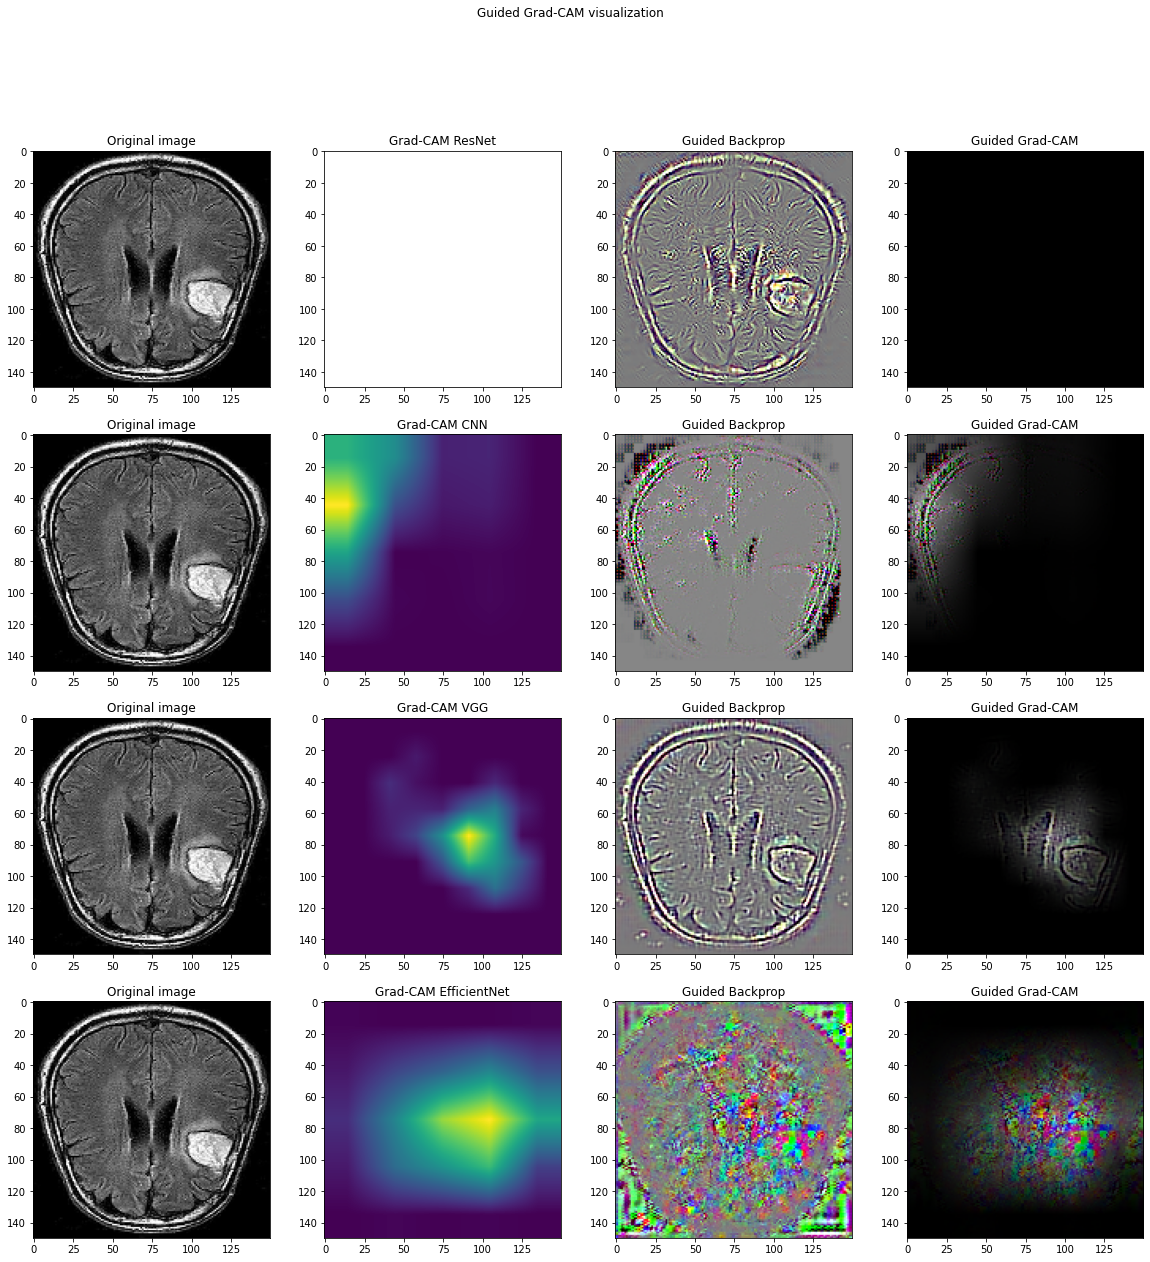

In [ ]:
# fig, axs = plt.subplots(4, 4, figsize=(20,20))
# fig.suptitle("Guided Grad-CAM visualization")


# guidedBackpropResnet = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, img_array)
# heatmapResNet = gradcam.make_gradcam_heatmap(np.array([img_array]), resnetModel, last_conv_layer_name_resnet)
# heatmapResNet = cv2.resize(heatmapResNet, dsize=(150, 150))
# guidedGradCAMResnet = np.uint8(heatmapResNet[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
# print(heatmapResNet.min())
# axs[0, 0].imshow(img)
# axs[0, 0].set_title("Original image")

# axs[0, 1].imshow(heatmapResNet)
# axs[0, 1].set_title("Grad-CAM ResNet")

# axs[0, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
# axs[0, 2].set_title("Guided Backprop")

# axs[0, 3].imshow(guidedGradCAMResnet)
# axs[0, 3].set_title("Guided Grad-CAM")



# guidedBackpropCNN = guided_backprop.create_saliency_map(modelCNN, last_conv_layer_name_cnn, img_array)
# heatmapCNN = gradcam.make_gradcam_heatmap(np.array([img_array]), modelCNN, last_conv_layer_name_cnn)
# heatmapCNN = cv2.resize(heatmapCNN, dsize=(150, 150))
# guidedGradCAMCNN = np.uint8(heatmapCNN[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))

# axs[1, 0].imshow(img)
# axs[1, 0].set_title("Original image")

# axs[1, 1].imshow(heatmapCNN)
# axs[1, 1].set_title("Grad-CAM CNN")

# axs[1, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))
# axs[1, 2].set_title("Guided Backprop")

# axs[1, 3].imshow(guidedGradCAMCNN)
# axs[1, 3].set_title("Guided Grad-CAM")



# guidedBackpropVGG = guided_backprop.create_saliency_map(vgg16Model, last_conv_layer_name_vgg16, img_array)
# heatmapVGG = gradcam.make_gradcam_heatmap(np.array([img_array]), vgg16Model, last_conv_layer_name_vgg16)
# heatmapVGG = cv2.resize(heatmapVGG, dsize=(150, 150))
# guidedGradCAMVGG = np.uint8(heatmapVGG[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVGG)),-1))

# axs[2, 0].imshow(img)
# axs[2, 0].set_title("Original image")

# axs[2, 1].imshow(heatmapVGG)
# axs[2, 1].set_title("Grad-CAM VGG")

# axs[2, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVGG)),-1))
# axs[2, 2].set_title("Guided Backprop")

# axs[2, 3].imshow(guidedGradCAMVGG)
# axs[2, 3].set_title("Guided Grad-CAM")



# guidedBackpropEfficient = guided_backprop.create_saliency_map(efficientNetModel, last_conv_layer_name_efficientnet, img_array)
# heatmapEfficient = gradcam.make_gradcam_heatmap(np.array([img_array]), efficientNetModel, last_conv_layer_name_efficientnet)
# heatmapEfficient = cv2.resize(heatmapEfficient, dsize=(150, 150))
# guidedGradCAMEfficient = np.uint8(heatmapEfficient[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficient)),-1))

# axs[3, 0].imshow(img)
# axs[3, 0].set_title("Original image")

# axs[3, 1].imshow(heatmapEfficient)
# axs[3, 1].set_title("Grad-CAM EfficientNet")

# axs[3, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficient)),-1))
# axs[3, 2].set_title("Guided Backprop")

# axs[3, 3].imshow(guidedGradCAMEfficient)
# axs[3, 3].set_title("Guided Grad-CAM")

# plt.show()

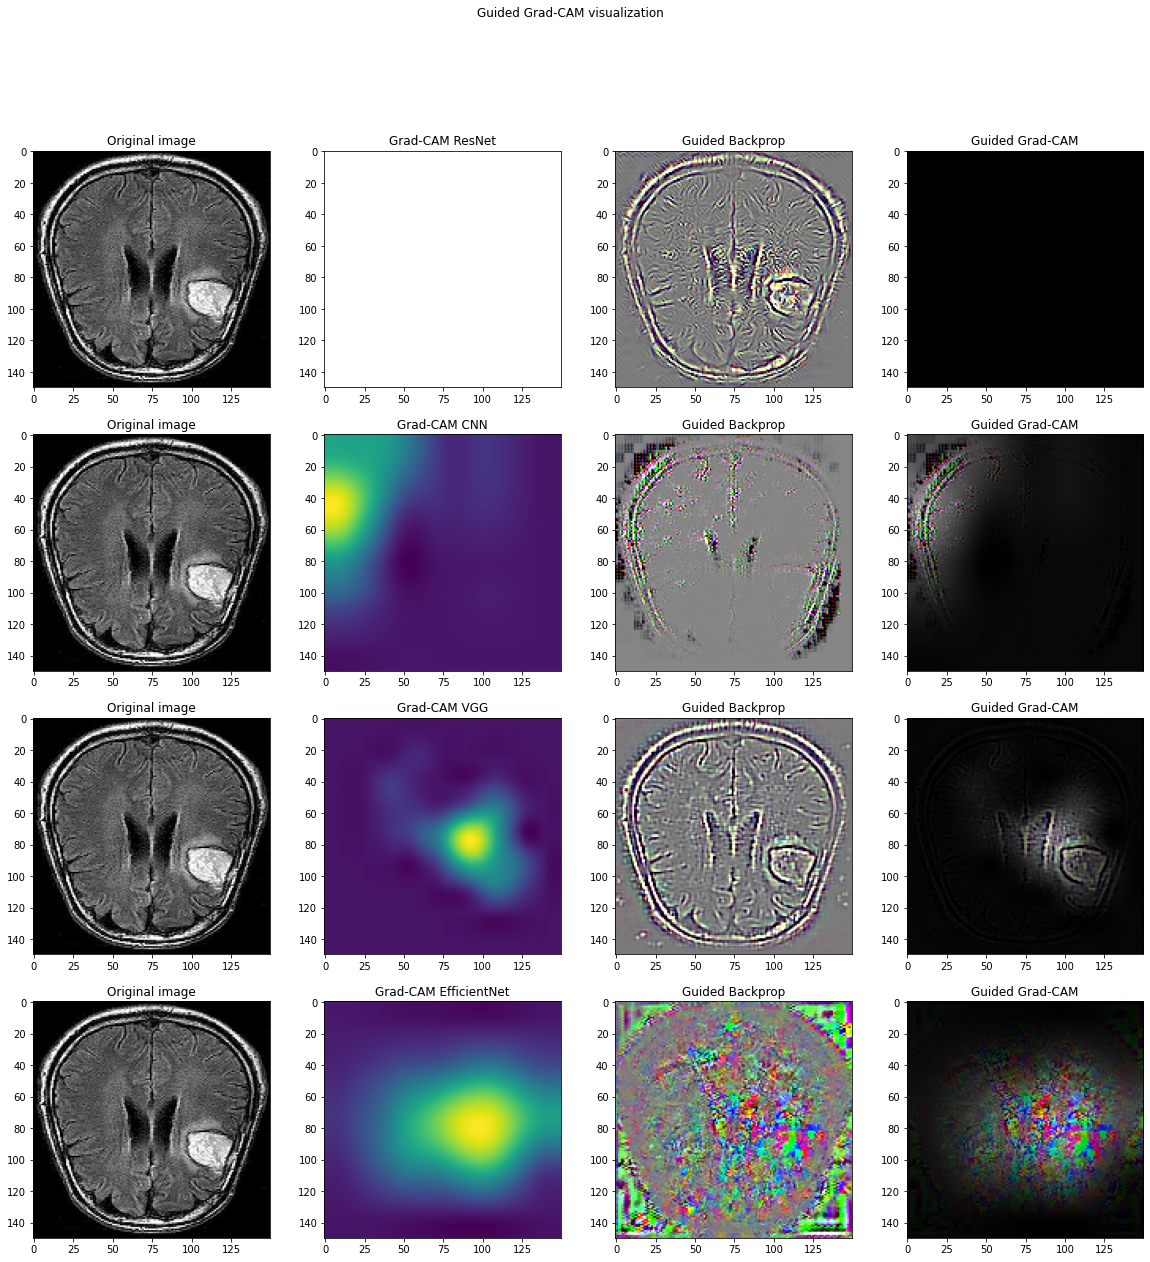

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))
fig.suptitle("Guided Grad-CAM visualization")


guidedBackpropResnet = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, img_array)
heatmapResNet = gradcam.make_gradcam_heatmap(np.array([img_array]), resnetModel, last_conv_layer_name_resnet)
heatmapResNet = cv2.resize(heatmapResNet, dsize=(150, 150), interpolation=cv2.INTER_CUBIC) 
heatmapResNet = (heatmapResNet-np.min(heatmapResNet))/(np.max(heatmapResNet)-np.min(heatmapResNet))
guidedGradCAMResnet = np.uint8(heatmapResNet[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original image")

axs[0, 1].imshow(heatmapResNet)
axs[0, 1].set_title("Grad-CAM ResNet")

axs[0, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
axs[0, 2].set_title("Guided Backprop")

axs[0, 3].imshow(guidedGradCAMResnet)
axs[0, 3].set_title("Guided Grad-CAM")



guidedBackpropCNN = guided_backprop.create_saliency_map(modelCNN, last_conv_layer_name_cnn, img_array)
heatmapCNN = gradcam.make_gradcam_heatmap(np.array([img_array]), modelCNN, last_conv_layer_name_cnn)
heatmapCNN = cv2.resize(heatmapCNN, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
heatmapCNN = (heatmapCNN-np.min(heatmapCNN))/(np.max(heatmapCNN)-np.min(heatmapCNN))
guidedGradCAMCNN = np.uint8(heatmapCNN[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))

axs[1, 0].imshow(img)
axs[1, 0].set_title("Original image")

axs[1, 1].imshow(heatmapCNN)
axs[1, 1].set_title("Grad-CAM CNN")

axs[1, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))
axs[1, 2].set_title("Guided Backprop")

axs[1, 3].imshow(guidedGradCAMCNN)
axs[1, 3].set_title("Guided Grad-CAM")



guidedBackpropVGG = guided_backprop.create_saliency_map(vgg16Model, last_conv_layer_name_vgg16, img_array)
heatmapVGG = gradcam.make_gradcam_heatmap(np.array([img_array]), vgg16Model, last_conv_layer_name_vgg16)
heatmapVGG = cv2.resize(heatmapVGG, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
heatmapVGG = (heatmapVGG-np.min(heatmapVGG))/(np.max(heatmapVGG)-np.min(heatmapVGG))
guidedGradCAMVGG = np.uint8(heatmapVGG[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVGG)),-1))

axs[2, 0].imshow(img)
axs[2, 0].set_title("Original image")

axs[2, 1].imshow(heatmapVGG)
axs[2, 1].set_title("Grad-CAM VGG")

axs[2, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVGG)),-1))
axs[2, 2].set_title("Guided Backprop")

axs[2, 3].imshow(guidedGradCAMVGG)
axs[2, 3].set_title("Guided Grad-CAM")



guidedBackpropEfficient = guided_backprop.create_saliency_map(efficientNetModel, last_conv_layer_name_efficientnet, img_array)
heatmapEfficient = gradcam.make_gradcam_heatmap(np.array([img_array]), efficientNetModel, last_conv_layer_name_efficientnet)
heatmapEfficient = cv2.resize(heatmapEfficient, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
heatmapEfficient = (heatmapEfficient-np.min(heatmapEfficient))/(np.max(heatmapEfficient)-np.min(heatmapEfficient))
guidedGradCAMEfficient = np.uint8(heatmapEfficient[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficient)),-1))

axs[3, 0].imshow(img)
axs[3, 0].set_title("Original image")

axs[3, 1].imshow(heatmapEfficient)
axs[3, 1].set_title("Grad-CAM EfficientNet")

axs[3, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficient)),-1))
axs[3, 2].set_title("Guided Backprop")

axs[3, 3].imshow(guidedGradCAMEfficient)
axs[3, 3].set_title("Guided Grad-CAM")

plt.show()

## All methods comparision

In [ ]:
# Grad-CAM
heatmapResNet = gradcam.make_gradcam_heatmap(np.array([img_array]), resnetModel, last_conv_layer_name_resnet)
gradcamResNet = gradcam.save_and_display_gradcam(img, heatmapResNet)

# CAM
heatmapCamResnet, label_index = cam.get_class_activation_map(resnetModel, img_array, last_conv_layer_name_resnet)
camResnet = cam.save_and_display_cam(img, heatmapCamResnet)

# GuidedBackprop
guidedBackpropResnet = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, img_array)

# Guided Grad-CAM
guidedBackpropResnet = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, img_array)
heatmapResNet = gradcam.make_gradcam_heatmap(np.array([img_array]), resnetModel, last_conv_layer_name_resnet)
heatmapResNet = cv2.resize(heatmapResNet, dsize=(150, 150))
guidedGradCAMResnet = np.uint8(heatmapResNet[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))



# VISUALIZATION
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=1)

axs[0,0].imshow(gradcamResNet)
axs[0,0].set_title(f"Grad-CAM")
axs[0,0].axis('off')

axs[0,1].imshow(camResnet)
axs[0,1].set_title(f"CAM")
axs[0,1].axis('off')

axs[1,0].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
axs[1,0].set_title(f"Guided Backpropagation")
axs[1,0].axis('off')

axs[1,1].imshow(guidedGradCAMResnet)
axs[1,1].set_title(f"Guided Grad-CAM")
axs[1,1].axis('off')

plt.show()

NameError: ignored

## Garbish

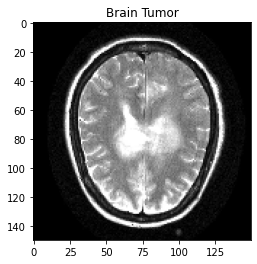

In [ ]:
idx = random.randint(0, len(X_train))

img = X_train[idx]
label = Y_train[idx]
img_array = img 
plt.imshow(img)
plt.title(labelsMapping[np.argmax(label)])
plt.show()

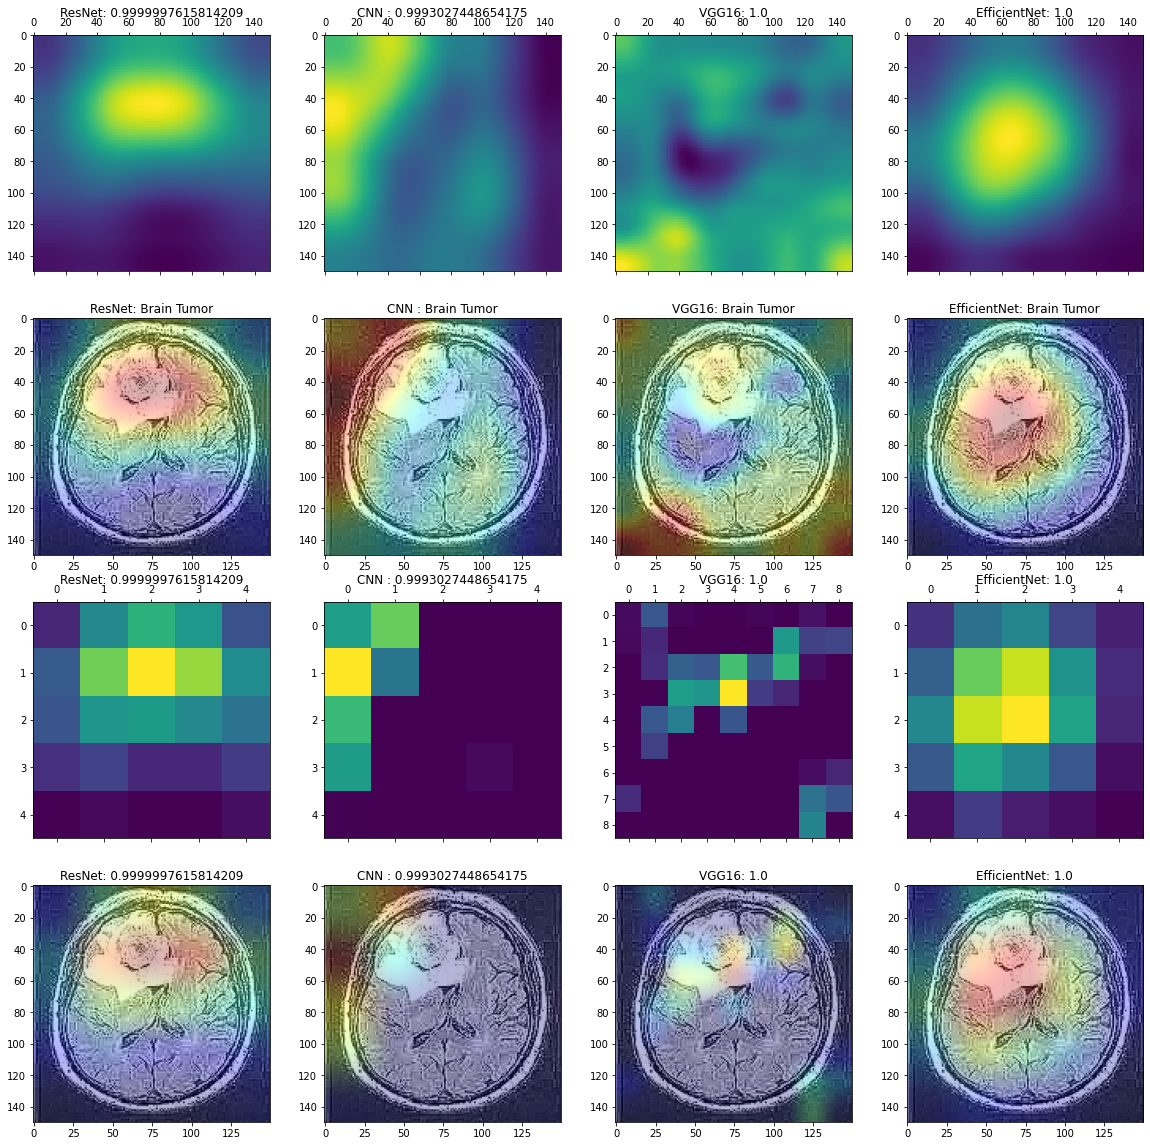

In [ ]:
heatmapCamResnet, label_index = cam.get_class_activation_map(resnetModel, img_array, last_conv_layer_name_resnet)
camResnet = cam.save_and_display_cam(img, heatmapCamResnet)

heatmapCamCNN, label_index = cam.get_class_activation_map(modelCNN, img_array, last_conv_layer_name_cnn)
camCNN = cam.save_and_display_cam(img, heatmapCamCNN)

heatmapCamVgg, cam.label_index = get_class_activation_map(vgg16Model, img_array, last_conv_layer_name_vgg16)
camVgg = cam.save_and_display_cam(img, heatmapCamVgg)

heatmapCamEfficient, label_index = cam.get_class_activation_map(efficientNetModel, img_array, last_conv_layer_name_efficientnet)
camEfficient = cam.save_and_display_cam(img, heatmapCamEfficient)

fig, axs = plt.subplots(4, 4, figsize=(20, 20)) 

axs[0, 0].matshow(heatmapCamResnet)
axs[0, 0].set_title(f"ResNet: {np.max(predictionResNet)}")

axs[0, 1].matshow(heatmapCamCNN)
axs[0, 1].set_title(f"CNN : {np.max(predictionCNN)}")

axs[0, 2].matshow(heatmapCamVgg)
axs[0, 2].set_title(f"VGG16: {np.max(predictionVgg16)}")

axs[0, 3].matshow(heatmapCamEfficient)
axs[0, 3].set_title(f"EfficientNet: {np.max(predictionEfficientNet)}")

axs[1, 0].imshow(camResnet)
axs[1, 0].set_title(f"ResNet: {labelsMapping[np.argmax(predictionResNet)]}")

axs[1, 1].imshow(camCNN)
axs[1, 1].set_title(f"CNN : {labelsMapping[np.argmax(predictionCNN)]}")

axs[1, 2].imshow(camVgg)
axs[1, 2].set_title(f"VGG16: {labelsMapping[np.argmax(predictionVgg16)]}")

axs[1, 3].imshow(camEfficient)
axs[1, 3].set_title(f"EfficientNet: {labelsMapping[np.argmax(predictionEfficientNet)]}")

heatmapResNet = gradcam.make_gradcam_heatmap(np.array([img_array]), resnetModel, last_conv_layer_name_resnet)
heatmapCNN = gradcam.make_gradcam_heatmap(np.array([img_array]), modelCNN, last_conv_layer_name_cnn)
heatmapVgg16 = gradcam.make_gradcam_heatmap(np.array([img_array]), vgg16Model, last_conv_layer_name_vgg16)
heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([img_array]), efficientNetModel, last_conv_layer_name_efficientnet)


axs[2, 0].matshow(heatmapResNet)
axs[2, 0].set_title(f"ResNet: {np.max(predictionResNet)}")

axs[2, 1].matshow(heatmapCNN)
axs[2, 1].set_title(f"CNN : {np.max(predictionCNN)}")

axs[2, 2].matshow(heatmapVgg16)
axs[2, 2].set_title(f"VGG16: {np.max(predictionVgg16)}")

axs[2, 3].matshow(heatmapEfficientNet)
axs[2, 3].set_title(f"EfficientNet: {np.max(predictionEfficientNet)}")

gradcamResNet = gradcam.save_and_display_gradcam(img, heatmapResNet)
gradcamCNN = gradcam.save_and_display_gradcam(img, heatmapCNN)
gradcamVgg16 = gradcam.save_and_display_gradcam(img, heatmapVgg16)
gradcamEfficientNet = gradcam.save_and_display_gradcam(img, heatmapEfficientNet)

axs[3, 0].imshow(gradcamResNet)
axs[3, 0].set_title(f"ResNet: {np.max(predictionResNet)}")

axs[3, 1].imshow(gradcamCNN)
axs[3, 1].set_title(f"CNN : {np.max(predictionCNN)}")

axs[3, 2].imshow(gradcamVgg16)
axs[3, 2].set_title(f"VGG16: {np.max(predictionVgg16)}")

axs[3, 3].imshow(gradcamEfficientNet)
axs[3, 3].set_title(f"EfficientNet: {np.max(predictionEfficientNet)}")


plt.show()

## Wnioski

- dla VGG widzę największą różnicę pomiędzy CAM i Grad-CAM. Grad-Cam przesuwa wizualizację w odpowiednim kierunku.

- CAM zwraca bardziej kolorowe mapy.

# Tests

## Sposoby:

- Dla danej architektury, która daje dobre wyniki (ResNet, EfficientNet, może VGG) zastosować metody analizy istotności i porównać je.
- Dla różnych architektur porównać działanie jednej metody, np. wziąć wszystkie architektury, zastosować dla nich Grad-CAM, Guided-GradCAM i porównać wyniki.
- Porównać wyniki dla CAM i GradCAM.


## Wnioski ogólne

- Guided-GradCAM tak naprawdę wymaga wyznaczenia wyników dwóch metod, co może być czasochłodne i utrudniać stosowanie Real-Time.
- CAM działa tylko dla ograniczonych architektur.
- Najlepszy Guided-GradCAM jeśli nie zależy nam na czasie, jeśli zależy to Grad-CAM.


## Tests

## Manual Tests

### Import libraries

In [ ]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/BrainTumor/')

from saliency_maps import gradcam, cam, guided_backprop
from IPython.display import clear_output

### Iterate over images and calculate Heatmaps

In [ ]:
for i in range(len(X_val)):
  # Clear cell output
  clear_output(wait=True)

  # Get image and true label
  image = X_val[i]
  label = Y_val[i]

  # Grad-CAM
  heatmapResNet = gradcam.make_gradcam_heatmap(np.array([image]), resnetModel, last_conv_layer_name_resnet)
  gradcamResNet = gradcam.save_and_display_gradcam(image, heatmapResNet)

  heatmapCNN = gradcam.make_gradcam_heatmap(np.array([image]), modelCNN, last_conv_layer_name_cnn)
  gradcamCNN = gradcam.save_and_display_gradcam(image, heatmapCNN)

  heatmapVgg16 = gradcam.make_gradcam_heatmap(np.array([image]), vgg16Model, last_conv_layer_name_vgg16)
  gradcamVgg16 = gradcam.save_and_display_gradcam(image, heatmapVgg16)

  heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([image]), efficientNetModel, last_conv_layer_name_efficientnet)
  gradcamEfficientNet = gradcam.save_and_display_gradcam(image, heatmapEfficientNet)

  # CAM
  heatmapCamResnet, predictionResnet = cam.get_class_activation_map(resnetModel, image, last_conv_layer_name_resnet)
  camResnet = cam.save_and_display_cam(image, heatmapCamResnet)

  heatmapCamCNN, predictionCNN = cam.get_class_activation_map(modelCNN, image, last_conv_layer_name_cnn)
  camCNN = cam.save_and_display_cam(image, heatmapCamCNN)

  heatmapCamVgg, predictionVgg = cam.get_class_activation_map(vgg16Model, image, last_conv_layer_name_vgg16)
  camVgg = cam.save_and_display_cam(image, heatmapCamVgg)

  heatmapCamEfficient, predictionEfficientNet = cam.get_class_activation_map(efficientNetModel, image, last_conv_layer_name_efficientnet)
  camEfficient = cam.save_and_display_cam(image, heatmapCamEfficient)

  # Guided Backprop
  guidedBackpropResnet = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, image)
  guidedBackpropCNN = guided_backprop.create_saliency_map(modelCNN, last_conv_layer_name_cnn, image)
  guidedBackpropVgg16 = guided_backprop.create_saliency_map(vgg16Model, last_conv_layer_name_vgg16, image)
  guidedBackpropEfficientnet = guided_backprop.create_saliency_map(efficientNetModel, last_conv_layer_name_efficientnet, image)

  # GuidedGradCAM
  heatmapResNetInter = cv2.resize(heatmapResNet, dsize=(150, 150), interpolation=cv2.INTER_CUBIC) 
  heatmapResNetInter = (heatmapResNetInter-np.min(heatmapResNetInter))/(np.max(heatmapResNetInter)-np.min(heatmapResNetInter))
  guidedGradCAMResnet = np.uint8(heatmapResNetInter[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))

  heatmapCNNInter = cv2.resize(heatmapCNN, dsize=(150, 150), interpolation=cv2.INTER_CUBIC) 
  heatmapCNNInter = (heatmapCNNInter-np.min(heatmapCNNInter))/(np.max(heatmapCNNInter)-np.min(heatmapCNNInter))
  guidedGradCAMCNN = np.uint8(heatmapCNNInter[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))

  heatmapVgg16Inter = cv2.resize(heatmapVgg16, dsize=(150, 150), interpolation=cv2.INTER_CUBIC) 
  heatmapVgg16Inter = (heatmapVgg16Inter-np.min(heatmapVgg16Inter))/(np.max(heatmapVgg16Inter)-np.min(heatmapVgg16Inter))
  guidedGradCAMVgg = np.uint8(heatmapVgg16Inter[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVgg16)),-1))

  heatmapEfficientNetInter = cv2.resize(heatmapEfficientNet, dsize=(150, 150), interpolation=cv2.INTER_CUBIC) 
  heatmapEfficientNetInter = (heatmapEfficientNetInter-np.min(heatmapEfficientNetInter))/(np.max(heatmapEfficientNetInter)-np.min(heatmapEfficientNetInter))
  guidedGradCAMEfficientNet = np.uint8(heatmapEfficientNetInter[..., np.newaxis] * np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficientnet)),-1))
  
  # Predictions
  predictionResNet = resnetModel.predict(np.array([image]), verbose=0)
  predictionCNN = modelCNN.predict(np.array([image]), verbose=0)
  predictionVgg16 = vgg16Model.predict(np.array([image]), verbose=0)
  predictionEfficientNet = efficientNetModel.predict(np.array([image]), verbose=0)

  # print(f"ResNet prediction: {labelsMapping[np.argmax(predictionResNet)]} {predictionResNet}")
  # print(f"CNN prediction: {labelsMapping[np.argmax(predictionCNN)]} {predictionCNN}")
  # print(f"VGG prediction: {labelsMapping[np.argmax(predictionVgg16)]} {predictionVgg16}")
  # print(f"EfficientNet prediction: {labelsMapping[np.argmax(predictionEfficientNet)]} {predictionEfficientNet}")

  fig, axs = plt.subplots(4, 4, figsize=(20,20))

  fig.suptitle(f"Image number: {i}. Predictions: ResNet: {np.max(predictionResNet)} {labelsMapping[np.argmax(predictionResNet)]} CNN: {np.max(predictionCNN)} {labelsMapping[np.argmax(predictionCNN)]} VGG: {np.max(predictionVgg16)} {labelsMapping[np.argmax(predictionVgg16)]} EfficientNet: {np.max(predictionEfficientNet)} {labelsMapping[np.argmax(predictionEfficientNet)]}")
  axs[0, 0].imshow(gradcamResNet)
  axs[0, 0].set_title(f"ResNet Grad-CAM")

  axs[0, 1].imshow(gradcamCNN)
  axs[0, 1].set_title(f"CNN Grad-CAM")

  axs[0, 2].imshow(gradcamVgg16)
  axs[0, 2].set_title(f"VGG Grad-CAM")

  axs[0, 3].imshow(gradcamEfficientNet)
  axs[0, 3].set_title(f"EfficientNet Grad-CAM")

  axs[1, 0].imshow(camResnet)
  axs[1, 0].set_title(f"ResNet CAM")

  axs[1, 1].imshow(camCNN)
  axs[1, 1].set_title(f"CNN CAM")

  axs[1, 2].imshow(camVgg)
  axs[1, 2].set_title(f"VGG CAM")

  axs[1, 3].imshow(camEfficient)
  axs[1, 3].set_title(f"EfficientNet CAM")

  axs[2, 0].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropResnet)),-1))
  axs[2, 0].set_title("ResNet GuidedBackprop")

  axs[2, 1].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropCNN)),-1))
  axs[2, 1].set_title("CNN GuidedBackprop")

  axs[2, 2].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropVgg16)),-1))
  axs[2, 2].set_title("VGG GuidedBackprop")

  axs[2, 3].imshow(np.flip(guided_backprop.deprocess_image(np.array(guidedBackpropEfficientnet)),-1))
  axs[2, 3].set_title("EfficientNet GuidedBackprop")

  axs[3, 0].imshow(guidedGradCAMResnet)
  axs[3, 0].set_title("ResNet Guided GradCAM")

  axs[3, 1].imshow(guidedGradCAMCNN)
  axs[3, 1].set_title("CNN Guided GradCAM")

  axs[3, 2].imshow(guidedGradCAMVgg)
  axs[3, 2].set_title("VGG Guided GradCAM")

  axs[3, 3].imshow(guidedGradCAMEfficientNet)
  axs[3, 3].set_title("EfficientNet Guided GradCAM")
  plt.savefig(f"/content/drive/MyDrive/BrainTumor/ManualTests/Img{i}.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


## Center of mass

In [ ]:
import imageio as iio
from skimage import filters
from skimage.color import rgb2gray  # only needed for incorrectly saved images
from skimage.measure import regionprops

def center_of_mass(image):
  if np.isnan(image).any():
    empty = np.empty(2)
    empty[:] = np.nan
    return empty
  threshold_value = filters.threshold_otsu(image)
  labeled_foreground = (image > threshold_value).astype(int)
  properties = regionprops(labeled_foreground, image)
  center_of_mass = properties[0].centroid
  weighted_center_of_mass = np.array(properties[0].weighted_centroid)

  return weighted_center_of_mass

### Grad-CAM CoM

#### Calculate center of map for every heatmap

In [ ]:
resnetCenters = list()
cnnCenters = list()
vggCenters = list()
efficientnetCenters = list()

for i in range(len(X_val)):
  image = X_val[i]
  # label = Y_val[i]
  heatmapResNet = gradcam.make_gradcam_heatmap(np.array([image]), resnetModel, last_conv_layer_name_resnet)
  heatmapCNN = gradcam.make_gradcam_heatmap(np.array([image]), modelCNN, last_conv_layer_name_cnn)
  heatmapVgg16 = gradcam.make_gradcam_heatmap(np.array([image]), vgg16Model, last_conv_layer_name_vgg16)
  heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([image]), efficientNetModel, last_conv_layer_name_efficientnet)

  if np.isnan(heatmapResNet).any() or np.isnan(heatmapCNN).any() or np.isnan(heatmapVgg16).any() or np.isnan(heatmapEfficientNet).any():
    continue
    
  resnetCenters.append(center_of_mass(heatmapResNet))
  cnnCenters.append(center_of_mass(heatmapCNN))
  vggCenters.append(center_of_mass(heatmapVgg16)/1.8) # skalowanie bo obraz 9x9 a chcemy 5x5
  efficientnetCenters.append(center_of_mass(heatmapEfficientNet))


resnetCenters = np.array(resnetCenters)
cnnCenters = np.array(cnnCenters)
vggCenters = np.array(vggCenters)
efficientnetCenters = np.array(efficientnetCenters)

In [ ]:
print(resnetCenters.shape)

(764, 2)


#### Visualize results as a matrix

L2 norm

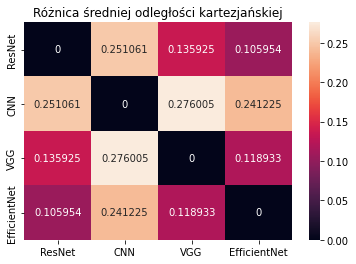

In [ ]:
import seaborn as sns
labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
centers = [resnetCenters, cnnCenters, vggCenters, efficientnetCenters]

avgCenters = np.zeros((len(centers), len(centers)))
for i in range(len(centers)):
  for j in range(len(centers)):

    avgCenters[i, j] = np.linalg.norm(centers[i] - centers[j], axis=1).mean()

ax= plt.subplot()
max_distance = np.sqrt(4**2 + 4**2)
sns.heatmap(avgCenters/max_distance, annot=True, fmt='g', ax=ax);

ax.set_title('Różnica średniej odległości kartezjańskiej'); 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

Only Tumor Images

In [ ]:
import imageio as iio
from skimage import filters
from skimage.color import rgb2gray  # only needed for incorrectly saved images
from skimage.measure import regionprops

def center_of_mass(image):
  if np.isnan(image).any():
    return np.array([0, 0])
  threshold_value = filters.threshold_otsu(image)
  labeled_foreground = (image > threshold_value).astype(int)
  properties = regionprops(labeled_foreground, image)
  center_of_mass = properties[0].centroid
  weighted_center_of_mass = np.array(properties[0].weighted_centroid)

  return weighted_center_of_mass


resnetOTCenters = list()
cnnOTCenters = list()
vggOTCenters = list()
efficientnetOTCenters = list()

for i in range(len(X_val)):
  if labelsMapping[np.argmax(Y_val[i])] != "Brain Tumor":
    continue
  image = X_val[i]
  # label = Y_val[i]
  heatmapResNet = gradcam.make_gradcam_heatmap(np.array([image]), resnetModel, last_conv_layer_name_resnet)
  heatmapCNN = gradcam.make_gradcam_heatmap(np.array([image]), modelCNN, last_conv_layer_name_cnn)
  heatmapVgg16 = gradcam.make_gradcam_heatmap(np.array([image]), vgg16Model, last_conv_layer_name_vgg16)
  heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([image]), efficientNetModel, last_conv_layer_name_efficientnet)

  empty = np.array([0, 0])
  if np.isnan(heatmapResNet).any() or np.isnan(heatmapCNN).any() or np.isnan(heatmapVgg16).any() or np.isnan(heatmapEfficientNet).any():
    continue
  resnetOTCenters.append(center_of_mass(heatmapResNet))
  cnnOTCenters.append(center_of_mass(heatmapCNN))
  vggOTCenters.append(center_of_mass(heatmapVgg16)/1.8)
  efficientnetOTCenters.append(center_of_mass(heatmapEfficientNet))


resnetOTCenters = np.array(resnetOTCenters)
cnnOTCenters = np.array(cnnOTCenters)
vggOTCenters = np.array(vggOTCenters)
efficientnetOTCenters = np.array(efficientnetOTCenters)

XY miara L2

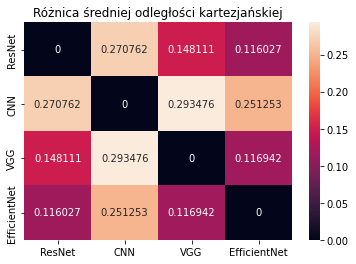

In [ ]:
import seaborn as sns
labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
OTcenters = [resnetOTCenters, cnnOTCenters, vggOTCenters, efficientnetOTCenters]

avgOTCenters = np.zeros((len(OTcenters), len(OTcenters)))
for i in range(len(OTcenters)):
  for j in range(len(OTcenters)):
    avgOTCenters[i, j] = np.linalg.norm(OTcenters[i] - OTcenters[j], axis=1).mean()

ax= plt.subplot()
max_distance = np.sqrt(4**2 + 4**2)
sns.heatmap(avgOTCenters/max_distance, annot=True, fmt='g', ax=ax);

ax.set_title('Różnica średniej odległości kartezjańskiej'); 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

DODAĆ WYKRES CENTER OF MASS DIFFERENCE vs NUMER ZDJĘCIA

POLICZYĆ DLA INTERPOLOWANEJ!!!!

### CAM CoM

In [ ]:
resnetCentersCAM = list()
cnnCentersCAM = list()
vggCentersCAM = list()
efficientnetCentersCAM = list()

for i in range(len(X_val)):
  image = X_val[i]
  # label = Y_val[i]
  heatmapCamResnet, label_index = cam.get_class_activation_map(resnetModel, image, last_conv_layer_name_resnet)
  heatmapCamCNN, label_index = cam.get_class_activation_map(modelCNN, image, last_conv_layer_name_cnn)
  heatmapCamVgg, label_index = cam.get_class_activation_map(vgg16Model, image, last_conv_layer_name_vgg16)
  heatmapCamEfficient, label_index = cam.get_class_activation_map(efficientNetModel, image, last_conv_layer_name_efficientnet)
  
  if np.isnan(heatmapCamResnet).any() or np.isnan(heatmapCamCNN).any() or np.isnan(heatmapCamVgg).any() or np.isnan(heatmapCamEfficient).any():
    continue
    
  resnetCentersCAM.append(center_of_mass(heatmapCamResnet))
  cnnCentersCAM.append(center_of_mass(heatmapCamCNN))
  vggCentersCAM.append(center_of_mass(heatmapCamVgg))
  efficientnetCentersCAM.append(center_of_mass(heatmapCamEfficient))


resnetCentersCAM = np.array(resnetCentersCAM)
cnnCentersCAM = np.array(cnnCentersCAM)
vggCentersCAM = np.array(vggCentersCAM)
efficientnetCentersCAM = np.array(efficientnetCentersCAM)

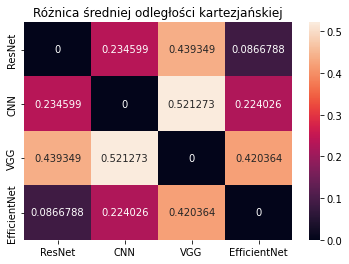

In [ ]:
import seaborn as sns
labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
centersCAM = [resnetCentersCAM, cnnCentersCAM, vggCentersCAM, efficientnetCentersCAM]

avgCentersCAM = np.zeros((len(centersCAM), len(centersCAM)))
for i in range(len(centersCAM)):
  for j in range(len(centersCAM)):
    avgCentersCAM[i, j] = np.linalg.norm(centersCAM[i] - centersCAM[j], axis=1).mean()

ax= plt.subplot()
max_distance = np.sqrt(149**2 + 149**2)
sns.heatmap(avgCentersCAM/max_distance, annot=True, fmt='g', ax=ax);

ax.set_title('Różnica średniej odległości kartezjańskiej'); 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

In [ ]:
OTresnetCentersCAM = list()
OTcnnCentersCAM = list()
OTvggCentersCAM = list()
OTefficientnetCentersCAM = list()

for i in range(len(X_val)):
  if labelsMapping[np.argmax(Y_val[i])] != "Brain Tumor":
    continue
  image = X_val[i]
  # label = Y_val[i]
  heatmapCamResnet, label_index = cam.get_class_activation_map(resnetModel, image, last_conv_layer_name_resnet)
  heatmapCamCNN, label_index = cam.get_class_activation_map(modelCNN, image, last_conv_layer_name_cnn)
  heatmapCamVgg, label_index = cam.get_class_activation_map(vgg16Model, image, last_conv_layer_name_vgg16)
  heatmapCamEfficient, label_index = cam.get_class_activation_map(efficientNetModel, image, last_conv_layer_name_efficientnet)

  if np.isnan(heatmapCamResnet).any() or np.isnan(heatmapCamCNN).any() or np.isnan(heatmapCamVgg).any() or np.isnan(heatmapCamEfficient).any():
    continue
    
  OTresnetCentersCAM.append(center_of_mass(heatmapCamResnet))
  OTcnnCentersCAM.append(center_of_mass(heatmapCamCNN))
  OTvggCentersCAM.append(center_of_mass(heatmapCamVgg))
  OTefficientnetCentersCAM.append(center_of_mass(heatmapCamEfficient))


OTresnetCentersCAM = np.array(OTresnetCentersCAM)
OTcnnCentersCAM = np.array(OTcnnCentersCAM)
OTvggCentersCAM = np.array(OTvggCentersCAM)
OTefficientnetCentersCAM = np.array(OTefficientnetCentersCAM)

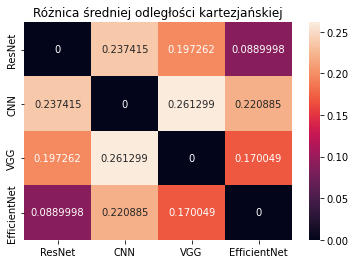

In [ ]:
import seaborn as sns
labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
OTcentersCAM = [OTresnetCentersCAM, OTcnnCentersCAM, OTvggCentersCAM, OTefficientnetCentersCAM]

OTavgCentersCAM = np.zeros((len(OTcentersCAM), len(OTcentersCAM)))
for i in range(len(OTcentersCAM)):
  for j in range(len(OTcentersCAM)):
    OTavgCentersCAM[i, j] = np.linalg.norm(OTcentersCAM[i] - OTcentersCAM[j], axis=1).mean()

ax= plt.subplot()
max_distance = np.sqrt(149**2 + 149**2)
sns.heatmap(OTavgCentersCAM/max_distance, annot=True, fmt='g', ax=ax);

ax.set_title('Różnica średniej odległości kartezjańskiej'); 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

Znormalizowane do przedziału (0, 1) gdzie 1 to szerokość zdjęcia.

### Guided Backprop CoM

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import numpy as np


H, W = 150, 150
# Reference: https://github.com/eclique/keras-gradcam/blob/master/grad_cam.py

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# @tf.RegisterGradient("GuidedRelu")
# def _GuidedReluGrad(op, grad):
#    gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
#    gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
#    return gate_f * gate_R * grad

def create_saliency_map(model, layer_name, img_array):

  with tf.compat.v1.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
    gb_model = Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(layer_name).output]
    )
    
    with tf.GradientTape() as tape:
      inputs = tf.cast(np.array([img_array]), tf.float32)
      tape.watch(inputs)
      outputs = gb_model(inputs)

  return tape.gradient(outputs,inputs)[0]

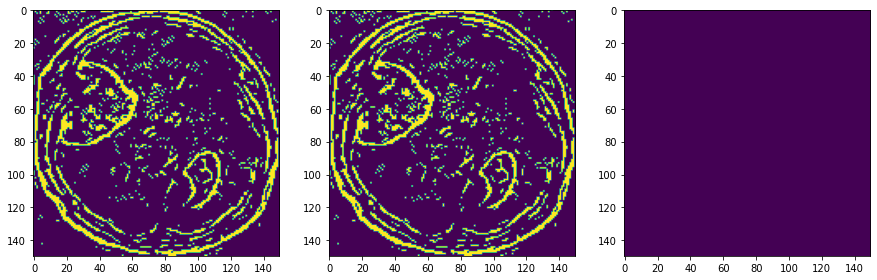

In [ ]:
image = X_val[77]

heatmapResNet1 = guided_backprop.create_saliency_map(resnetModel, last_conv_layer_name_resnet, image)
picture = cv2.cvtColor(np.flip(guided_backprop.deprocess_image(np.array(heatmapResNet1)), -1), cv2.COLOR_RGB2GRAY)
threshold_value = filters.threshold_otsu(picture)
labeled_foreground1 = (picture > threshold_value).astype(int)

heatmapResNet2 = create_saliency_map(resnetModel, last_conv_layer_name_resnet, image)
picture = cv2.cvtColor(np.flip(guided_backprop.deprocess_image(np.array(heatmapResNet2)), -1), cv2.COLOR_RGB2GRAY)
threshold_value = filters.threshold_otsu(picture)
labeled_foreground2 = (picture > threshold_value).astype(int)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(labeled_foreground1)
axs[1].imshow(labeled_foreground2)
axs[2].imshow(np.abs(labeled_foreground1 - labeled_foreground2))
plt.show()

In [ ]:
resnetCenters = list()

for i in range(len(X_val)):
  image = X_val[i]
  # label = Y_val[i]
  heatmapResNet = create_saliency_map(resnetModel, last_conv_layer_name_resnet, image)
  heatmapResNetNP = np.flip(guided_backprop.deprocess_image(np.array(heatmapResNet)),-1)
  picture = cv2.cvtColor(heatmapResNetNP, cv2.COLOR_RGB2GRAY)

  threshold_value = filters.threshold_otsu(picture)
  labeled_foreground = (picture > threshold_value).astype(int)
  
  print(picture.shape)
  if np.isnan(picture).any():
    continue

  resnetCenters.append(center_of_mass(picture))
  CoM = center_of_mass(picture)
  
  plt.imshow(labeled_foreground)
  plt.plot(CoM[0], CoM[1], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
  plt.show()

  if 0 < i < 30:
    plt.imshow(labeled_foreground)
    plt.plot(CoM[0], CoM[1], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
    plt.show()
  
  if i == 29:
    break
resnetCenters = np.array(resnetCenters)

Output hidden; open in https://colab.research.google.com to view.

## IoU

#### Create Intersection Over Union method

In [ ]:
def IoU(img1, img2):
  commonArea = np.sum((img1 > 0) & (img2 > 0))
  totalArea = np.sum((img1 > 0) | (img2 > 0))

  IoU = commonArea / totalArea
  return IoU

### Grad-CAM

#### Calculate IoU for all heatmaps

In [ ]:
# heatmapsResNet = list()
# heatmapsCNN = list()
# heatmapsVgg16 = list()
# heatmapsEfficientNet = list()

In [ ]:
IoUs = dict()
LowIoUs = dict()
HighIoUs = dict()
labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
for i in range(len(labels)):
  for j in range(len(labels)):
    if i != j:
      IoUs[labels[i] + "+" + labels[j]] = list()
      LowIoUs[labels[i] + "+" + labels[j]] = list()
      HighIoUs[labels[i] + "+" + labels[j]] = list()

for idx in range(len(X_val)):
  # Take only Brain Tumor images
  if labelsMapping[np.argmax(Y_val[idx])] != "Brain Tumor":
    continue
  image = X_val[idx]

  # Create Grad-CAM heatmaps
  heatmapResNet = gradcam.make_gradcam_heatmap(np.array([image]), resnetModel, last_conv_layer_name_resnet)
  heatmapCNN = gradcam.make_gradcam_heatmap(np.array([image]), modelCNN, last_conv_layer_name_cnn)
  heatmapVgg16 = gradcam.make_gradcam_heatmap(np.array([image]), vgg16Model, last_conv_layer_name_vgg16)
  heatmapVgg16 = cv2.resize(heatmapVgg16, (5, 5), interpolation=cv2.INTER_AREA) # TODO: Co z tym zrobić?
  heatmapEfficientNet = gradcam.make_gradcam_heatmap(np.array([image]), efficientNetModel, last_conv_layer_name_efficientnet)

  # if not np.isnan(heatmapResNet).any():
  #   heatmapsResNet.append(heatmapResNet)
  
  # if not np.isnan(heatmapCNN).any():
  #   heatmapsCNN.append(heatmapCNN)
  
  # if not np.isnan(heatmapVgg16).any():
  #   heatmapsVgg16.append(heatmapVgg16)
  
  # if not np.isnan(heatmapEfficientNet).any():
  #   heatmapsEfficientNet.append(heatmapEfficientNet)
    
  Chceck if heatmap is not broken
  if np.isnan(heatmapResNet).any() or np.isnan(heatmapCNN).any() or np.isnan(heatmapVgg16).any() or np.isnan(heatmapEfficientNet).any():
    continue
  
  # Check predictions for all models
  predictionResNet = np.argmax(resnetModel.predict(np.array([img_array]), verbose=0))
  predictionCNN = np.argmax(modelCNN.predict(np.array([img_array]), verbose=0))
  predictionVgg16 = np.argmax(vgg16Model.predict(np.array([img_array]), verbose=0))
  predictionEfficientNet = np.argmax(efficientNetModel.predict(np.array([img_array]), verbose=0))

  # Remove heatmaps for which model did not predict right
  labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
  heatmaps = [heatmapResNet, heatmapCNN, heatmapVgg16, heatmapEfficientNet]
  preds = [predictionResNet, predictionCNN, predictionVgg16, predictionEfficientNet]
  realPred = np.argmax(Y_val[idx])
  idxsToDelete = list()
  for i in range(len(labels)):
    if preds[i] != realPred:
      idxsToDelete.append(i)
  heatmaps = [heatmaps[i] for i in range(len(heatmaps)) if i not in idxsToDelete]
  labels = [labels[i] for i in range(len(labels)) if i not in idxsToDelete]

  # Iterate over heatmaps and compare by IoU
  for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
      if j > i:
        iou = IoU(heatmaps[i], heatmaps[j])
        IoUs[labels[i] + "+" + labels[j]].append(iou)
        if iou < 0.5:
          LowIoUs[labels[i] + "+" + labels[j]].append(idx)
        if iou > 0.9:
          HighIoUs[labels[i] + "+" + labels[j]].append(idx)

In [ ]:
print(f"Brain Tumor images: {Y_val.count([0, 1])}")
print(f"ResNet: {len(heatmapsResNet)} {len(heatmapsResNet) / Y_val.count([0, 1]) * 100} %")
print(f"CNN: {len(heatmapsCNN)} {len(heatmapsCNN) / Y_val.count([0, 1]) * 100} %")
print(f"VGG: {len(heatmapsVgg16)} {len(heatmapsVgg16) / Y_val.count([0, 1]) * 100} %")
print(f"EfficientNet: {len(heatmapsEfficientNet)} {len(heatmapsEfficientNet) / Y_val.count([0, 1]) * 100} %")

Brain Tumor images: 531
ResNet: 389 73.25800376647834 %
CNN: 531 100.0 %
VGG: 494 93.03201506591337 %
EfficientNet: 524 98.68173258003766 %


In [ ]:
keysToDelete = list()
for key, value in IoUs.items():
  if len(value) == 0:
    keysToDelete.append(key)

for key in keysToDelete:
  del IoUs[key]

In [ ]:
for key, value in IoUs.items():
  print(f"{key}: {len(value)}")

ResNet+CNN: 376
ResNet+VGG: 376
ResNet+EfficientNet: 376
CNN+VGG: 376
CNN+EfficientNet: 376
VGG+EfficientNet: 376


#### Visualize Intersection over Union

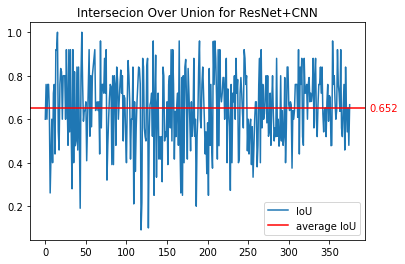

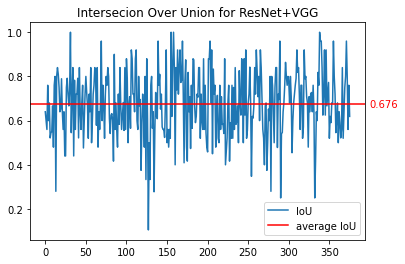

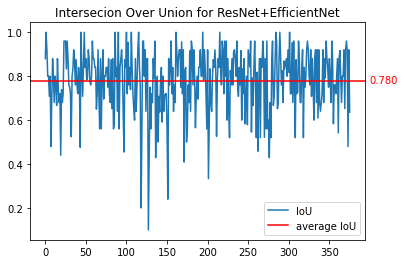

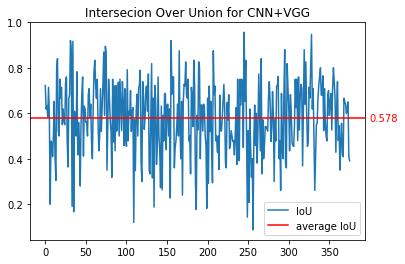

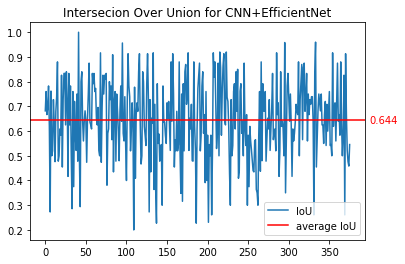

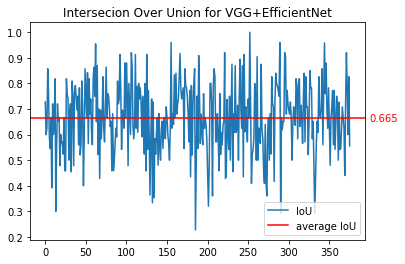

In [ ]:
import matplotlib.transforms as transforms

for key, value in IoUs.items():
  fig, ax = plt.subplots()
  ax.plot(value, label='IoU')
  ax.axhline(y = np.mean(value), color = 'r', linestyle = '-', label='average IoU')
  ax.legend(loc='lower right')
  ax.set_title(f"Intersecion Over Union for {key}")
  trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
  ax.text(1.12,np.mean(value), f"{np.mean(value):.3f}", color="red", transform=trans, 
        ha="right", va="center")
  plt.show()

#### Visualize average IoU

In [ ]:
# https://www.statology.org/seaborn-barplot-show-values/

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
import seaborn as sns

avgIOUs = list()
for key, value in IoUs.items():
  avgIOUs.append((key, np.mean(value)))

avgIOUs = sorted(avgIOUs, key=lambda x: x[1])

x = list()
y = list()
for elem in avgIOUs:
  x.append(elem[0])
  y.append(elem[1])

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x, y)

ax.set_title("Average IoU value for all network combinations")
show_values(ax)
ax.set_xlabel("CNNs combination")
ax.set_ylabel("Average IoU")
plt.show()

NameError: ignored

In [ ]:
print(f"AVG IOU for Grad-CAM: {np.mean([elem[1] for elem in avgIOUs])}")

### CAM

#### All images

In [ ]:
camIoUs = dict()
lists_initialized = False
for idx in range(len(X_val)):

  image = X_val[idx]
  # label = Y_val[idx]
  heatmapCamResnet, label_index = cam.get_class_activation_map(resnetModel, image, last_conv_layer_name_resnet)
  heatmapCamCNN, label_index = cam.get_class_activation_map(modelCNN, image, last_conv_layer_name_cnn)
  heatmapCamVgg, label_index = cam.get_class_activation_map(vgg16Model, image, last_conv_layer_name_vgg16)
  heatmapCamEfficient, label_index = cam.get_class_activation_map(efficientNetModel, image, last_conv_layer_name_efficientnet)

  if np.isnan(heatmapCamResnet).any() or np.isnan(heatmapCamCNN).any() or np.isnan(heatmapCamVgg).any() or np.isnan(heatmapCamEfficient).any():
    continue

  labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
  heatmaps = [heatmapCamResnet, heatmapCamCNN, heatmapCamVgg, heatmapCamEfficient]

  for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
      if j > i:
        if not lists_initialized:
          camIoUs[labels[i] + "+" + labels[j]] = list()

        camIoUs[labels[i] + "+" + labels[j]].append(IoU(heatmaps[i], heatmaps[j]))
  lists_initialized = True

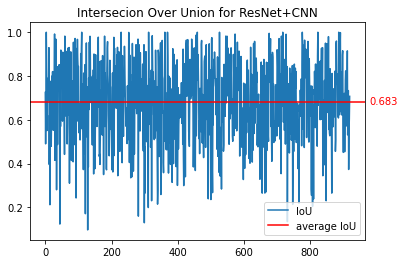

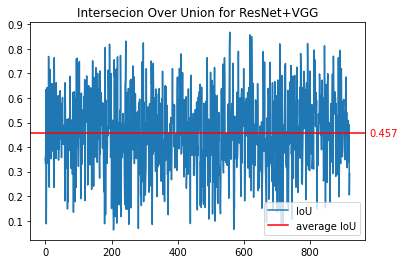

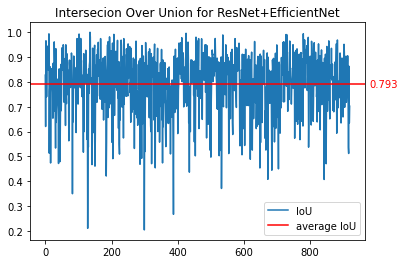

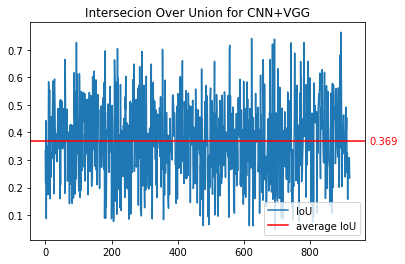

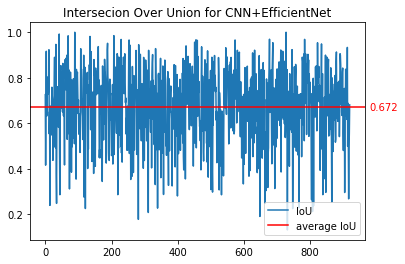

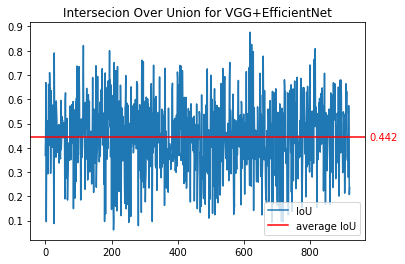

In [ ]:
import matplotlib.transforms as transforms

for key, value in camIoUs.items():
  fig, ax = plt.subplots()
  ax.plot(value, label='IoU')
  ax.axhline(y = np.mean(value), color = 'r', linestyle = '-', label='average IoU')
  ax.legend(loc='lower right')
  ax.set_title(f"Intersecion Over Union for {key}")
  trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
  ax.text(1.12,np.mean(value), f"{np.mean(value):.3f}", color="red", transform=trans, 
        ha="right", va="center")
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


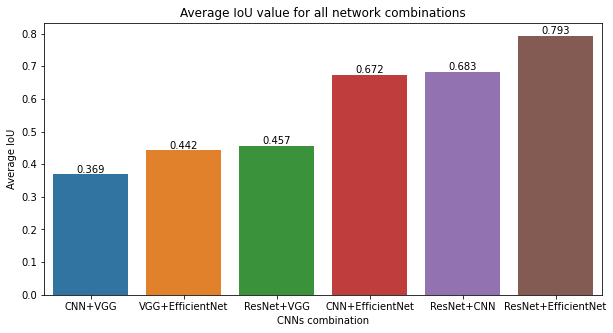

In [ ]:
import seaborn as sns

avgIOUsCAM = list()
for key, value in camIoUs.items():
  avgIOUsCAM.append((key, np.mean(value)))

avgIOUsCAM = sorted(avgIOUsCAM, key=lambda x: x[1])

x = list()
y = list()
for elem in avgIOUsCAM:
  x.append(elem[0])
  y.append(elem[1])

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x, y)

ax.set_title("Average IoU value for all network combinations")
show_values(ax)
ax.set_xlabel("CNNs combination")
ax.set_ylabel("Average IoU")
plt.show()

In [ ]:
print(f"AVG IOU for CAM: {np.mean([elem[1] for elem in avgIOUsCAM])}")

AVG IOU for CAM: 0.5693647145962134


#### Images with Brain Tumor only

In [ ]:
camIoUs = dict()
camLowIoUs = dict()
camHighIoUs = dict()
lists_initialized = False
for idx in range(len(X_val)):
  if labelsMapping[np.argmax(Y_val[idx])] != "Brain Tumor":
    continue
  image = X_val[idx]
  # label = Y_val[idx]
  heatmapCamResnet, label_index = cam.get_class_activation_map(resnetModel, image, last_conv_layer_name_resnet)
  heatmapCamCNN, label_index = cam.get_class_activation_map(modelCNN, image, last_conv_layer_name_cnn)
  heatmapCamVgg, label_index = cam.get_class_activation_map(vgg16Model, image, last_conv_layer_name_vgg16)
  heatmapCamEfficient, label_index = cam.get_class_activation_map(efficientNetModel, image, last_conv_layer_name_efficientnet)

  if np.isnan(heatmapCamResnet).any() or np.isnan(heatmapCamCNN).any() or np.isnan(heatmapCamVgg).any() or np.isnan(heatmapCamEfficient).any():
    continue

  labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
  heatmaps = [heatmapCamResnet, heatmapCamCNN, heatmapCamVgg, heatmapCamEfficient]

  for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
      if j > i:
        if not lists_initialized:
          camIoUs[labels[i] + "+" + labels[j]] = list()
          camLowIoUs[labels[i] + "+" + labels[j]] = list()
          camHighIoUs[labels[i] + "+" + labels[j]] = list()
        iou = IoU(heatmaps[i], heatmaps[j])
        camIoUs[labels[i] + "+" + labels[j]].append(iou)
        if iou < 0.5:
          camLowIoUs[labels[i] + "+" + labels[j]].append(idx)
        if iou > 0.9:
          camHighIoUs[labels[i] + "+" + labels[j]].append(idx)
  lists_initialized = True

In [ ]:
camIoUs = dict()
camLowIoUs = dict()
camHighIoUs = dict()
labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
for i in range(len(labels)):
  for j in range(len(labels)):
    camIoUs[labels[i] + "+" + labels[j]] = list()
    camLowIoUs[labels[i] + "+" + labels[j]] = list()
    camHighIoUs[labels[i] + "+" + labels[j]] = list()
    
for idx in range(len(X_val)):
  if labelsMapping[np.argmax(Y_val[idx])] != "Brain Tumor":
    continue
  image = X_val[idx]
  # label = Y_val[idx]
  heatmapCamResnet, labelIdxResnet = cam.get_class_activation_map(resnetModel, image, last_conv_layer_name_resnet)

  heatmapCamCNN, labelIdxCNN = cam.get_class_activation_map(modelCNN, image, last_conv_layer_name_cnn)

  heatmapCamVgg, labelIdxVGG = cam.get_class_activation_map(vgg16Model, image, last_conv_layer_name_vgg16)

  heatmapCamEfficient, labelIdxEfficient = cam.get_class_activation_map(efficientNetModel, image, last_conv_layer_name_efficientnet)

  if np.isnan(heatmapCamResnet).any() or np.isnan(heatmapCamCNN).any() or np.isnan(heatmapCamVgg).any() or np.isnan(heatmapCamEfficient).any():
    continue

  labels = ["ResNet", "CNN", "VGG", "EfficientNet"]
  heatmaps = [heatmapCamResnet, heatmapCamCNN, heatmapCamVgg, heatmapCamEfficient]
  preds = [labelIdxResnet, labelIdxCNN, labelIdxVGG, labelIdxEfficient]
  realPred = np.argmax(Y_val[idx])
  idxsToDelete = list()
  for i in range(len(labels)):
    if preds[i] != realPred:
      idxsToDelete.append(i)
  heatmaps = [heatmaps[i] for i in range(len(heatmaps)) if i not in idxsToDelete]
  labels = [labels[i] for i in range(len(labels)) if i not in idxsToDelete]

  for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
      if j > i:
        iou = IoU(heatmaps[i], heatmaps[j])
        camIoUs[labels[i] + "+" + labels[j]].append(iou)
        if iou < 0.5:
          camLowIoUs[labels[i] + "+" + labels[j]].append(idx)
        if iou > 0.9:
          camHighIoUs[labels[i] + "+" + labels[j]].append(idx)

In [ ]:
keysToDelete = list()
for key, value in camIoUs.items():
  if len(value) == 0:
    keysToDelete.append(key)

for key in keysToDelete:
  del camIoUs[key]

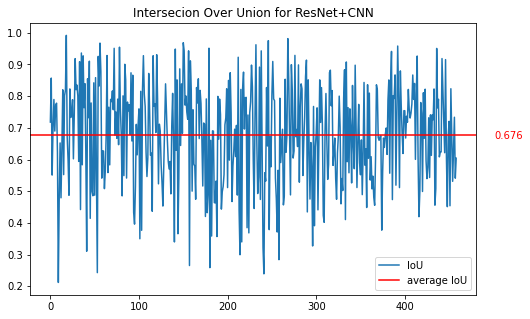

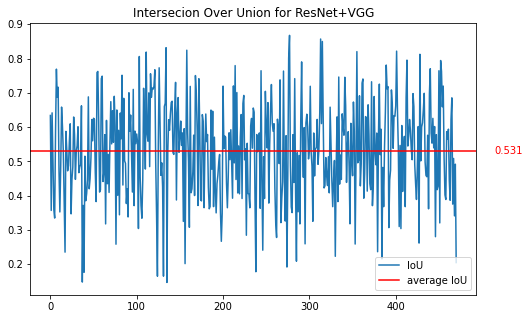

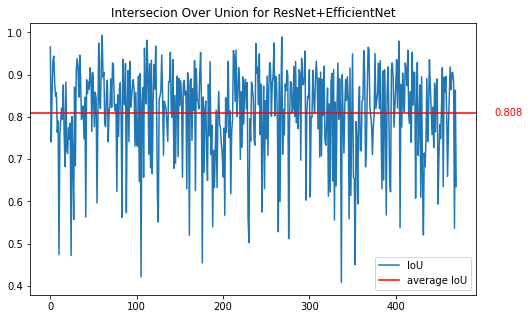

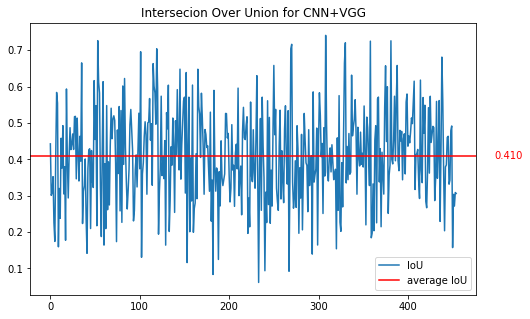

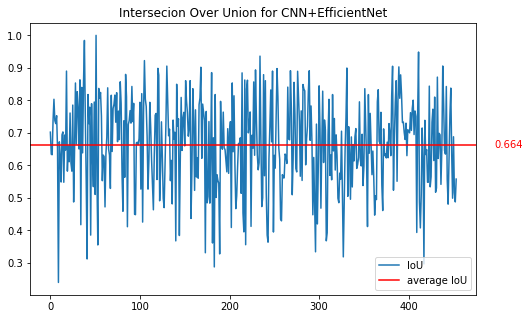

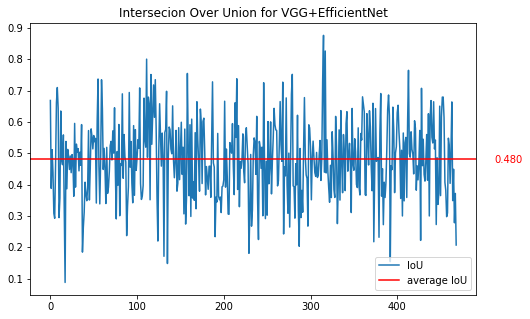

In [ ]:
import matplotlib.transforms as transforms

for key, value in camIoUs.items():
  fig, ax = plt.subplots(figsize=(8,5))
  ax.plot(value, label='IoU')
  ax.axhline(y = np.mean(value), color = 'r', linestyle = '-', label='average IoU')
  ax.legend(loc='lower right')
  ax.set_title(f"Intersecion Over Union for {key}")
  trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
  ax.text(1.12,np.mean(value), f"{np.mean(value):.3f}", color="red", transform=trans, 
        ha="right", va="center")
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


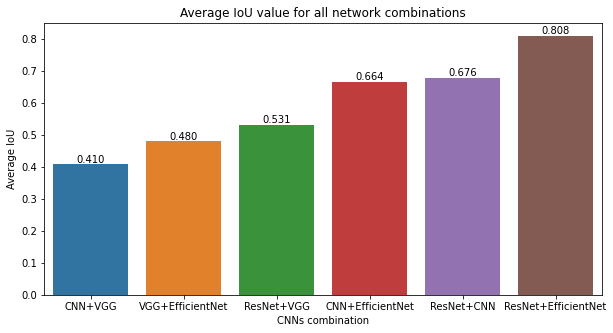

In [ ]:
import seaborn as sns

avgIOUsCAM = list()
for key, value in camIoUs.items():
  avgIOUsCAM.append((key, np.mean(value)))

avgIOUsCAM = sorted(avgIOUsCAM, key=lambda x: x[1])

x = list()
y = list()
for elem in avgIOUsCAM:
  x.append(elem[0])
  y.append(elem[1])

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x, y)

ax.set_title("Average IoU value for all network combinations")
show_values(ax)
ax.set_xlabel("CNNs combination")
ax.set_ylabel("Average IoU")
plt.show()

In [ ]:
print(f"AVG IOU for CAM: {np.mean([elem[1] for elem in avgIOUsCAM])}")

print("Indexes of images with low IoU")
for key, value in camLowIoUs.items():
  print(f"{key}: {value}")

print("Indexes of images with high IoU")
for key, value in camHighIoUs.items():
  print(f"{key}: {value}")

AVG IOU for CAM: 0.5906376103275791
Indexes of images with low IoU
ResNet+CNN: [14, 16, 18, 37, 58, 73, 79, 83, 86, 88, 93, 142, 163, 165, 176, 184, 208, 230, 247, 262, 266, 296, 299, 301, 318, 338, 344, 346, 349, 357, 365, 367, 372, 380, 381, 387, 402, 415, 417, 418, 423, 435, 447, 453, 466, 477, 484, 491, 492, 504, 522, 530, 532, 538, 539, 555, 587, 593, 598, 600, 605, 615, 618, 640, 642, 650, 655, 657, 669, 684, 725, 737, 748, 750, 763, 782, 839, 847, 876, 900, 904]
ResNet+VGG: [4, 7, 8, 16, 17, 18, 25, 26, 35, 37, 40, 41, 43, 48, 53, 55, 58, 67, 68, 69, 71, 73, 74, 77, 79, 89, 91, 93, 98, 99, 101, 104, 105, 108, 111, 113, 129, 132, 134, 144, 151, 154, 155, 157, 163, 166, 176, 184, 186, 187, 189, 192, 202, 220, 221, 223, 230, 231, 238, 240, 244, 266, 284, 288, 299, 301, 304, 306, 307, 310, 318, 325, 331, 332, 338, 349, 351, 357, 364, 366, 368, 372, 373, 374, 377, 380, 381, 382, 392, 393, 396, 403, 404, 406, 413, 416, 418, 423, 437, 450, 454, 460, 461, 476, 477, 487, 491, 492, 496, 5